<a href="https://colab.research.google.com/github/anjalii-s/Machine-Learning-Coursework---Predictive-models-for-currency-circulation-in-Latvia/blob/main/Forecasting_currency_circulation_in_Latvia_using_central_bank_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div style="display:flex; align-items:center; justify-content:space-between; background:#667eea;
            padding:15px; border-radius:10px; color:white; max-width:700px; margin:20px auto;">
  
  <!-- Heading on the left -->
  <div style="flex:1; text-align:left; padding-left:10px;">
    <h2 style="margin:0; font-size:28px;">
      Forecasting Currency Circulation in Latvia using Latvijas Banka Data : time series based Econometric and Machine learning models </p>
   
  </div>
  
  <!-- Image on the right -->
  <div style="flex:0 0 40px; text-align:right; padding-right:10px;">
    <img src="https://thumbs.dreamstime.com/b/money-coins-growing-income-times-clock-business-objects-164877556.jpg"
         style="width:40px; height:40px; border-radius:50%;">
  </div>
</div>



In this work we will try to forecast currency in circulation in Latvia using Latvijas Banka( Latvian central bank ) details available online.(Link in the references). ECB rates have been added to the dataset as money circulation is dependent on many other factors (exogenous factors). This  course work focuses on machine learning methods to predict money circulation .The available dataset has 141 observations from Jan 2014 to Sep 2025 monthly data.This is a real-world small dataset.All currency is in millions of Euros.

# Data loading and exploration

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Plot settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
df = pd.read_csv("final_merged_data.csv")
df.head()


,Date,National contribution to the euro area monetary base,Currency in circulation,Current account holdings of credit institutions with Latvijas Banka,Deposit facility,Credit,To MFIs in the euro area,To general government in the euro area,To other resident sectors in the euro area,External assets outside euro area,External liabilities outside euro area,ECB_Deposit_Rate
0,01-01-2014,5831.9,3779.6,1417.3,635.0,1683.9,522.8,298.6,862.5,2768.3,46.5,0.0
1,01-02-2014,5905.9,3727.9,1218.9,959.1,1595.5,434.8,298.7,862.0,2734.1,20.5,0.0
2,01-03-2014,5852.2,3715.4,1191.8,945.0,1615.9,451.6,283.2,881.1,2752.2,3.3,0.0
3,01-04-2014,5692.5,3736.3,1206.2,750.0,1611.7,487.8,273.0,850.9,2729.0,28.4,0.0
4,01-05-2014,5785.1,3745.6,999.5,1040.0,1583.2,493.3,273.6,816.3,2813.4,62.0,0.0


This dataset helps us track how Latvia’s central bank balances, credit flows, and ECB policy rates evolve over time, and how they relate to the currency in circulation.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 12 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Date                                                                 141 non-null    object 
 1   National contribution to the euro area monetary base                 141 non-null    float64
 2   Currency in circulation                                              141 non-null    float64
 3   Current account holdings of credit institutions with Latvijas Banka  141 non-null    float64
 4   Deposit facility                                                     141 non-null    float64
 5   Credit                                                               141 non-null    float64
 6   To MFIs in the euro area                                             141 non-null    float64
 7   To gener

The dataset set needs cleaning to change date type, there exist some multicollinearity from the initial observation. We will make the heatmap after looking at the statistics.

In [ ]:
df.describe()

,National contribution to the euro area monetary base,Currency in circulation,Current account holdings of credit institutions with Latvijas Banka,Deposit facility,Credit,To MFIs in the euro area,To general government in the euro area,To other resident sectors in the euro area,External assets outside euro area,External liabilities outside euro area,ECB_Deposit_Rate
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,9433.556028,4819.436170,3150.860993,1463.258865,5035.729787,633.887943,3187.245390,1214.596454,8687.707092,485.407801,0.485816
std,2099.425564,737.081743,2138.749592,2433.053280,1662.047216,403.257167,1771.926118,520.094056,3501.777503,696.312928,1.520319
min,4429.100000,3715.400000,180.600000,0.000000,1577.200000,195.400000,272.700000,354.500000,2729.000000,0.600000,-0.500000
25%,8149.800000,4147.800000,453.800000,0.000000,4261.000000,307.200000,2003.800000,847.600000,5620.000000,9.800000,-0.400000
50%,9808.400000,4645.900000,3976.300000,0.000000,4803.900000,551.300000,2309.700000,930.000000,9031.800000,86.000000,-0.400000
75%,11072.700000,5625.800000,5093.800000,4368.400000,6468.000000,807.100000,4965.200000,1827.900000,11972.100000,728.300000,0.750000
max,14058.300000,5834.300000,6443.500000,7975.900000,7477.200000,1555.200000,5664.600000,1915.900000,12767.100000,2392.300000,4.000000


All currencies are in million euros.National contribution to euro area monetary base has average 9434m and there is moderate variability.

Currency in circulation average of 4819m and it is relatively stable compared to other variables.

Current account holdings of credit institutions- an average of 3151m,very volatile(std=2139m)

Deposit facility,median 0,often unused and range 7976,some months higher use.

Credit (total) ,Avergae 5036m,range 1577 to 7477-shows significant lending activity.

to MFI there is smaller lending and to general government in Euro area there is large fluctuations,wide spread seen.To other sectors moderate variability (std=520m).

External assets-large holdings and high variability(3502m)

external liabilities - much smaller,but highly skewed

ECB deposit rate- average 0.49%,median negative (-0.40%), reflecting ECB's negative rate policy.



#Preprocessing ,define target and exogenous variables

We change Date to datetime -right format from object.Our target is currency in circulation.
We will list the exogenous (independent) variables that may influence the target, such as ECB deposit rate, deposit facility, credit, and external assets/liabilities

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df = df.sort_values('Date').set_index('Date').asfreq('MS')

# Define target and exogenous variables
TARGET = 'Currency in circulation'
EXOGS = ['ECB_Deposit_Rate', 'Deposit facility', 'Credit',
         'External assets outside euro area', 'External liabilities outside euro area']



# Correlation heatmap

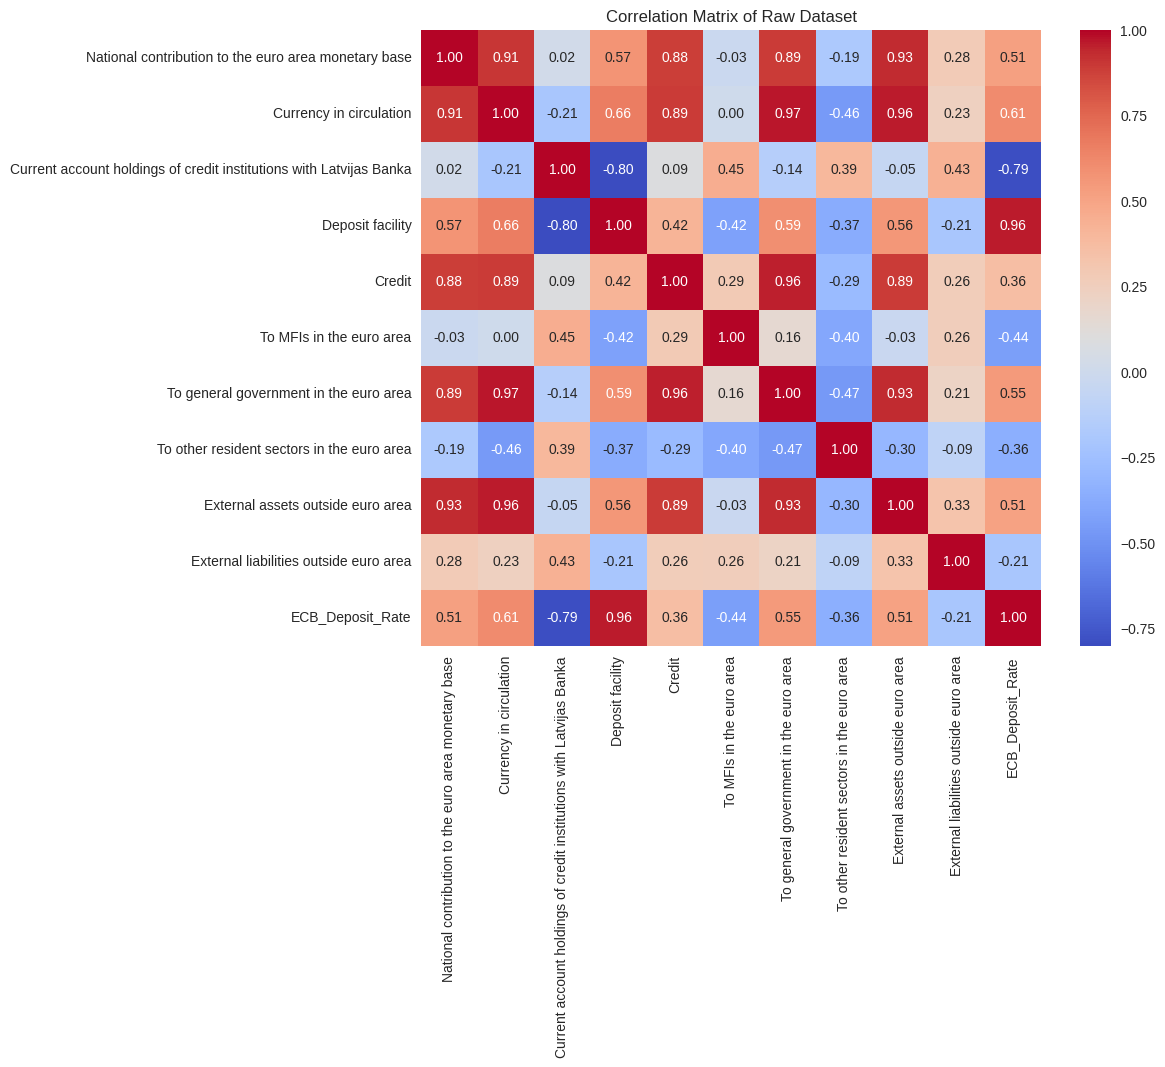

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Raw Dataset")
plt.show()

- Currency in circulation shows moderate correlation with Credit and External assets, indicating economic activity and cross-border flows may impact cash demand.

- Strong positive correlation nbetween deposit facility and ECB rate shows policy rate changes directly influence liquidity parked at the central bank.

- Negative correlation between deposit facility abd current account holdings reflects a liquidity trade-off between overnight balances and term deposits.

- High correlation between National contribution and Government credit (0.97) imply fiscal operations are tightly linked to Latvia's monetary base.

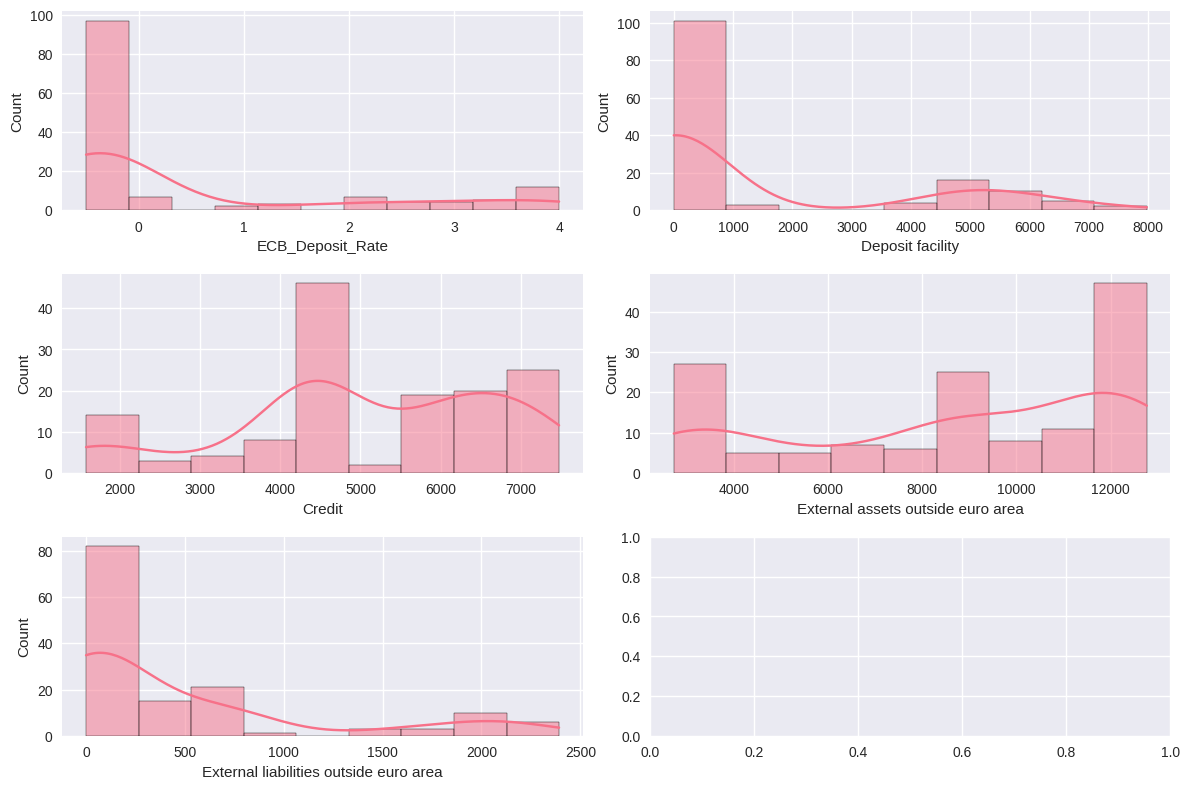

In [ ]:
# Distribution plots for exogenous variables
fig, axes = plt.subplots(3,2, figsize=(12,8))

sns.histplot(df["ECB_Deposit_Rate"], kde=True, ax=axes[0,0])
sns.histplot(df["Deposit facility"], kde=True, ax=axes[0,1])
sns.histplot(df["Credit"], kde=True, ax=axes[1,0])
sns.histplot(df["External assets outside euro area"], kde=True, ax=axes[1,1])
sns.histplot(df["External liabilities outside euro area"], kde=True, ax=axes[2,0])


plt.tight_layout()
plt.show()


The exogenous variables show skewed and varied distributions, with some clustering near zero and others widely spread.

# Fill missing values in exogenous variable and visualize target

To prepare the dataset for modeling, missing values in the exogenous variables are filled using interpolation and forward/backward filling. We will check the dataset’s shape, time coverage, and growth of the target variable, and then visualize Currency in Circulation over time.

Dataset shape: (141, 11)
Time period: 2014-01-01 to 2025-09-01
Target variable: Currency in circulation
Initial value: 3779.60
Final value: 5768.50
Growth: 52.6%


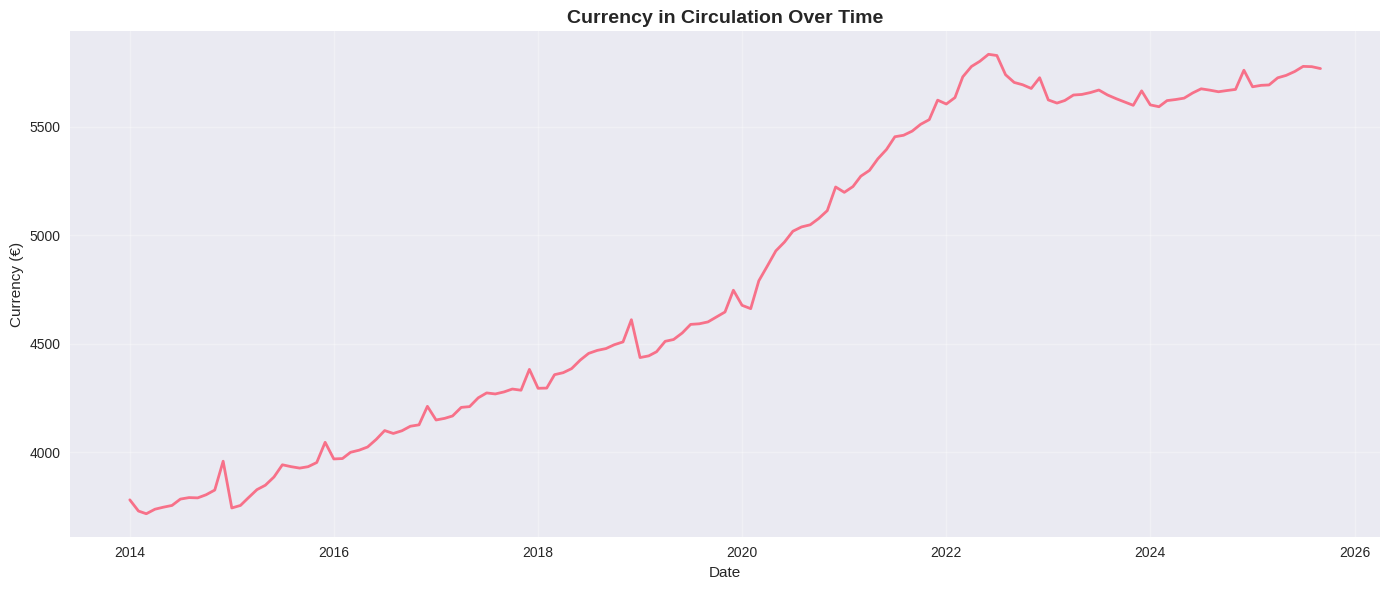

In [ ]:
# Fill missing values
df[EXOGS] = df[EXOGS].interpolate().fillna(method='ffill').fillna(method='bfill')

print(f"Dataset shape: {df.shape}")
print(f"Time period: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Target variable: {TARGET}")
print(f"Initial value: {df[TARGET].iloc[0]:.2f}")
print(f"Final value: {df[TARGET].iloc[-1]:.2f}")
print(f"Growth: {(df[TARGET].iloc[-1]/df[TARGET].iloc[0]-1)*100:.1f}%")

# Visualize the target variable
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[TARGET], linewidth=2)
plt.title('Currency in Circulation Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Currency (€)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

A clear upward trend in Currency in Circulation.It shows gradual growth with some fluctuations.

# Feature engineering

To prepare the dataset for machine learning modeling, we engineered additional features to capture autocorrelation, seasonality, and smoothed trends. Created lagged versions of the target variable (1, 3, and 12 months), rolling averages (3‑month and 12‑month), and month dummy variables to encode seasonality. These were combined with the original exogenous drivers (ECB deposit rate, deposit facility, credit, external assets/liabilities) to form a richer feature set.

In [ ]:

def create_lag_features(data, target_col, lags=[1, 3, 12]):
    """Create lag features and rolling statistics"""
    X = pd.DataFrame(index=data.index)

    # Lag features
    for lag in lags:
        X[f'{target_col}_lag{lag}'] = data[target_col].shift(lag)

    # Rolling statistics (shifted to avoid look-ahead bias)
    X['rolling_mean_3'] = data[target_col].shift(1).rolling(3).mean()
    X['rolling_mean_12'] = data[target_col].shift(1).rolling(12).mean()

    # Month dummies
    month_series = pd.Series(data.index.month, index=data.index, name='month')
    dummies = pd.get_dummies(month_series, prefix='m', drop_first=True)

    # Combine all features
    X = pd.concat([X, dummies], axis=1)
    return X

# Create lag features
lag_feats = create_lag_features(df, TARGET)

# Combine with original data
df_ml = pd.concat([df[[TARGET] + EXOGS], lag_feats], axis=1)

# Drop rows with NaN (from lag operations)
df_ml = df_ml.dropna(subset=lag_feats.columns).copy()

print(f"Original dataset shape: {df.shape}")
print(f"Feature-engineered dataset shape: {df_ml.shape}")
print(f"Number of features: {len(df_ml.columns) - 1}")

# Prepare features and target
X = df_ml.drop(columns=[TARGET])
y = df_ml[TARGET]

print(f"\nFeatures used:")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2}. {col}")

Original dataset shape: (141, 11)
Feature-engineered dataset shape: (129, 22)
Number of features: 21

Features used:
 1. ECB_Deposit_Rate
 2. Deposit facility
 3. Credit
 4. External assets outside euro area
 5. External liabilities outside euro area
 6. Currency in circulation_lag1
 7. Currency in circulation_lag3
 8. Currency in circulation_lag12
 9. rolling_mean_3
10. rolling_mean_12
11. m_2
12. m_3
13. m_4
14. m_5
15. m_6
16. m_7
17. m_8
18. m_9
19. m_10
20. m_11
21. m_12


The feature engineering expanded the dataset from 11 original variables to 21 predictive features, reducing the usable sample size to 129 observations due to lagging operations. The final feature set includes policy indicators, lagged CiC values, rolling statistics, and month dummies, providing the machine learning models with both temporal and seasonal context. This structured dataset forms the basis for our experiments.

The following visualizations illustrate the engineered features created by our pipeline. A) Lag plots show autocorrelation structure, B) rolling means highlight short‑ and long‑term trends, and C) month dummies capture seasonal variation in currency demand

A) Target vs Lag Features

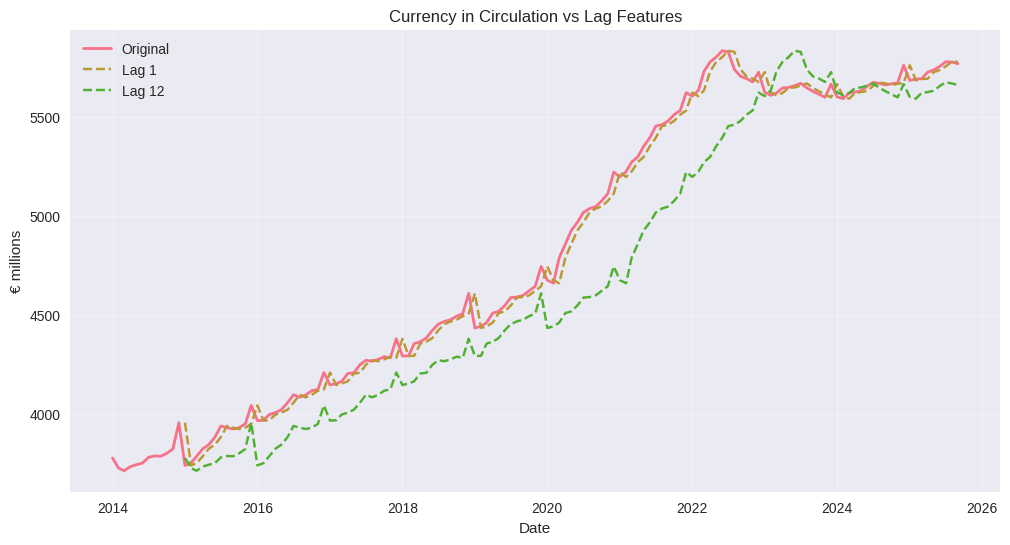

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Currency in circulation"], label="Original", linewidth=2)
plt.plot(df_ml.index, df_ml["Currency in circulation_lag1"], label="Lag 1", linestyle="--")
plt.plot(df_ml.index, df_ml["Currency in circulation_lag12"], label="Lag 12", linestyle="--")
plt.title("Currency in Circulation vs Lag Features")
plt.xlabel("Date")
plt.ylabel("€ millions")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


B) Rolling Means (Trend Smoothing)

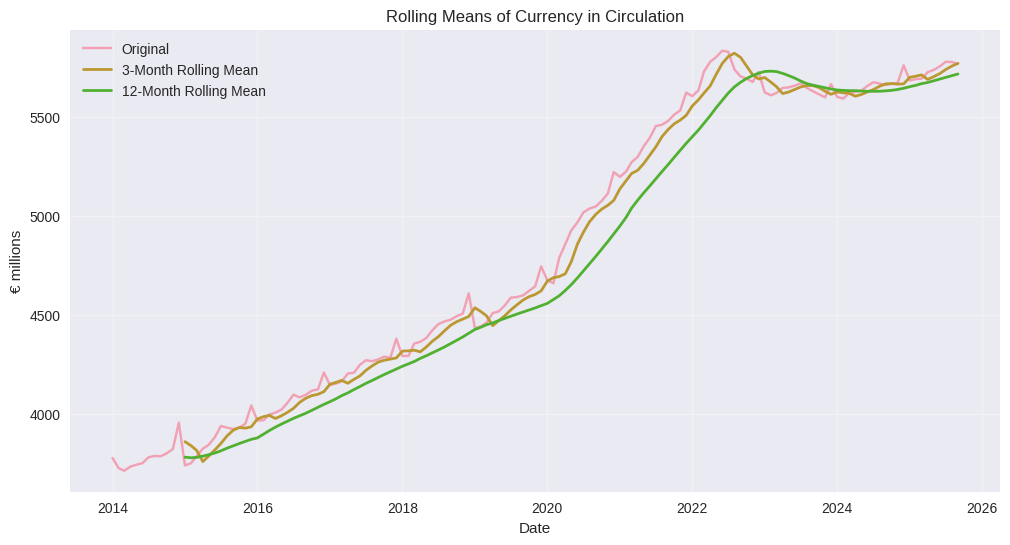

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Currency in circulation"], label="Original", alpha=0.6)
plt.plot(df_ml.index, df_ml["rolling_mean_3"], label="3-Month Rolling Mean", linewidth=2)
plt.plot(df_ml.index, df_ml["rolling_mean_12"], label="12-Month Rolling Mean", linewidth=2)
plt.title("Rolling Means of Currency in Circulation")
plt.xlabel("Date")
plt.ylabel("€ millions")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


C) Month Dummies (Seasonality Encoding)

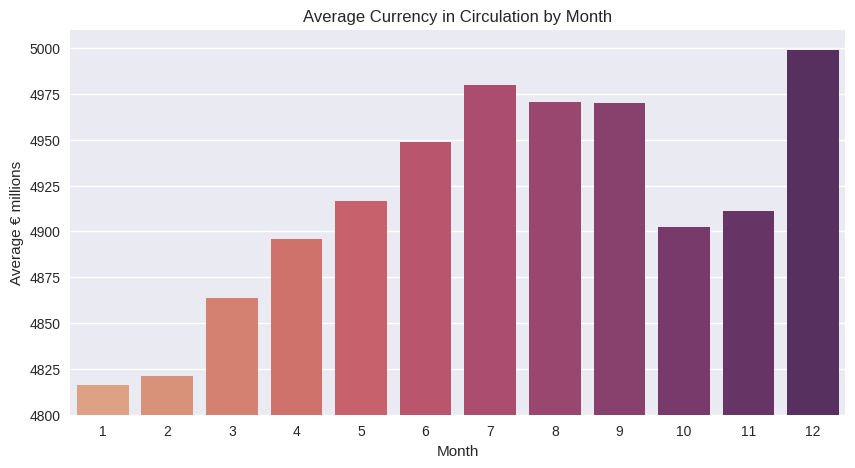

In [117]:
month_means = df_ml.groupby(df_ml.index.month)["Currency in circulation"].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=month_means.index, y=month_means.values, palette="flare")
plt.title("Average Currency in Circulation by Month")
plt.xlabel("Month")
plt.ylabel("Average € millions")
plt.ylim(4800, 5010)
plt.show()


# Stationarity analysis
We test for stationarity using ADF and KPSS.

**ADF-Augmented Dickey–Fuller Test** Used to check if a time series has a unit root (i.e., is non‑stationary).Null hypothesis (H₀): The series is non‑stationary.
If p‑value < 0.05 → reject H₀ → the series is stationary.


**KPSS → Kwiatkowski–Phillips–Schmidt–Shin Test**

Also used to test stationarity, but from the opposite perspective.

Null hypothesis (H₀): The series is stationary.

If p‑value < 0.05 → reject H₀ → the series is non‑stationary.



*Results guide whether differencing or detrending is required*.

**Differencing** means subtracting the previous value from the current value to remove trends and make a series more stable.

First difference (I(1)):
𝑦
𝑡
−
𝑦
𝑡
−
1
. Removes linear trends.

Second difference (I(2)):
(
𝑦
𝑡
−
𝑦
𝑡
−
1
)
−
(
𝑦
𝑡
−
1
−
𝑦
𝑡
−
2
)
. Removes stronger trends or curvature

**Detrending** means explicitly removing a fitted trend (linear or quadratic) from the series, leaving only the residual fluctuations.




In [ ]:


def comprehensive_stationarity_analysis(df, target_col, significance_level=0.05):
    """Complete stationarity analysis with transformations"""

    print("="*80)
    print("COMPREHENSIVE STATIONARITY ANALYSIS")
    print("="*80)

    results = {}

    def adf_test(series, name):
        """Augmented Dickey-Fuller test"""
        result = adfuller(series.dropna(), autolag="AIC")
        is_stationary = result[1] < significance_level
        results[name] = {
            'adf_statistic': result[0],
            'p_value': result[1],
            'stationary': is_stationary,
            'lags': result[2],
            'nobs': result[3],
            'critical_values': result[4]
        }
        print(f"{name:30s} | ADF: {result[0]:8.4f} | p-value: {result[1]:8.4f} | "
              f"Stationary: {'YES' if is_stationary else 'NO '}")
        return is_stationary

    def kpss_test(series, name):
        """KPSS test (null hypothesis: stationary)"""
        try:
            statistic, p_value, n_lags, critical_values = kpss(series.dropna(), nlags='auto')
            is_stationary = p_value > significance_level
            print(f"{name:30s} | KPSS: {statistic:8.4f} | p-value: {p_value:8.4f} | "
                  f"Stationary: {'YES' if is_stationary else 'NO '}")
            return is_stationary
        except:
            print(f"{name:30s} | KPSS test failed")
            return None

    print("\n" + "-"*80)
    print("ORIGINAL SERIES")
    print("-"*80)

    # Test target variable
    print("\nTARGET VARIABLE:")
    target_original_stat = adf_test(df[target_col], f"{target_col} (Original)")
    kpss_test(df[target_col], f"{target_col} (Original)")

    print("\nOTHER VARIABLES:")
    for col in df.columns:
        if col != target_col and col not in ['Year']:
            adf_test(df[col], f"{col} (Original)")

    print("\n" + "-"*80)
    print("FIRST DIFFERENCES")
    print("-"*80)

    # First differences
    print(f"\n{target_col}:")
    target_diff1 = df[target_col].diff().dropna()
    target_diff1_stat = adf_test(target_diff1, f"{target_col} (1st Diff)")

    print("\nOther variables (1st difference):")
    for col in ['Credit', 'ECB_Deposit_Rate', 'National contribution to the euro area monetary base']:
        if col in df.columns:
            diff1 = df[col].diff().dropna()
            adf_test(diff1, f"{col} (1st Diff)")

    print("\n" + "-"*80)
    print("SECOND DIFFERENCES")
    print("-"*80)

    # Second differences
    print(f"\n{target_col}:")
    target_diff2 = df[target_col].diff().diff().dropna()
    target_diff2_stat = adf_test(target_diff2, f"{target_col} (2nd Diff)")

    print("\nOther variables (2nd difference):")
    for col in ['Credit', 'ECB_Deposit_Rate']:
        if col in df.columns:
            diff2 = df[col].diff().diff().dropna()
            adf_test(diff2, f"{col} (2nd Diff)")

    print("\n" + "-"*80)
    print("LOG TRANSFORMATIONS")
    print("-"*80)

    # Log transformations
    print(f"\n{target_col}:")
    log_target = np.log(df[target_col])
    adf_test(log_target, f"{target_col} (Log)")

    log_target_diff1 = np.log(df[target_col]).diff().dropna()
    adf_test(log_target_diff1, f"{target_col} (Log 1st Diff)")

    log_target_diff2 = np.log(df[target_col]).diff().diff().dropna()
    adf_test(log_target_diff2, f"{target_col} (Log 2nd Diff)")

    print("\n" + "-"*80)
    print("DETERMINISTIC TREND REMOVAL")
    print("-"*80)

    # Remove linear trend
    from statsmodels.tsa.tsatools import detrend
    detrended_linear = detrend(df[target_col], order=1)
    adf_test(detrended_linear, f"{target_col} (Linear Detrended)")

    # Remove quadratic trend
    detrended_quad = detrend(df[target_col], order=2)
    adf_test(detrended_quad, f"{target_col} (Quadratic Detrended)")

    print("\n" + "-"*80)
    print("CONCLUSIONS:")
    print("-"*80)

    # Determine optimal transformation
    print(f"\nBased on ADF tests for {target_col}:")
    print(f"1. Original series: {'Non-stationary' if not target_original_stat else 'Stationary'}")
    print(f"2. First difference: {'Non-stationary' if not target_diff1_stat else 'Stationary'}")
    print(f"3. Second difference: {'Non-stationary' if not target_diff2_stat else 'Stationary'}")

    if target_diff2_stat:
        print("\nRECOMMENDATION: Use SECOND DIFFERENCES (I(2) process)")
        optimal_transform = 'second_difference'
    elif target_diff1_stat:
        print("\nRECOMMENDATION: Use FIRST DIFFERENCES (I(1) process)")
        optimal_transform = 'first_difference'
    else:
        print("\nRECOMMENDATION: Series may need higher-order differencing or structural break adjustment")
        optimal_transform = 'none'

    return results, optimal_transform

# Run stationarity analysis
stationarity_results, optimal_transform = comprehensive_stationarity_analysis(
    df, 'Currency in circulation'
)
stationarity_results, optimal_transform = comprehensive_stationarity_analysis(
    df, 'Currency in circulation'
)


COMPREHENSIVE STATIONARITY ANALYSIS

--------------------------------------------------------------------------------
ORIGINAL SERIES
--------------------------------------------------------------------------------

TARGET VARIABLE:
Currency in circulation (Original) | ADF:  -1.1386 | p-value:   0.6994 | Stationary: NO 
Currency in circulation (Original) | KPSS:   1.6234 | p-value:   0.0100 | Stationary: NO 

OTHER VARIABLES:
National contribution to the euro area monetary base (Original) | ADF:  -2.9541 | p-value:   0.0394 | Stationary: YES
Current account holdings of credit institutions with Latvijas Banka (Original) | ADF:  -1.3843 | p-value:   0.5898 | Stationary: NO 
Deposit facility (Original)    | ADF:  -0.9904 | p-value:   0.7567 | Stationary: NO 
Credit (Original)              | ADF:  -2.1888 | p-value:   0.2103 | Stationary: NO 
To MFIs in the euro area (Original) | ADF:  -1.8014 | p-value:   0.3798 | Stationary: NO 
To general government in the euro area (Original) | ADF:  -

We see the target series was non‑stationary in levels and first differences, but became stationary after second differencing (I(2)). So there is strong trend persistence, so we rely on SARIMAX, State Space, and VARX, which can incorporate exogenous drivers and handle non‑stationarity more flexibly than plain ARIMA/SARIMA.


To complement statistical tests, we will visualize the original and differenced series, along with autocorrelation functions, to confirm the presence of trend and the effectiveness of differencing.

**Time Series Plot (Original vs Differenced)**


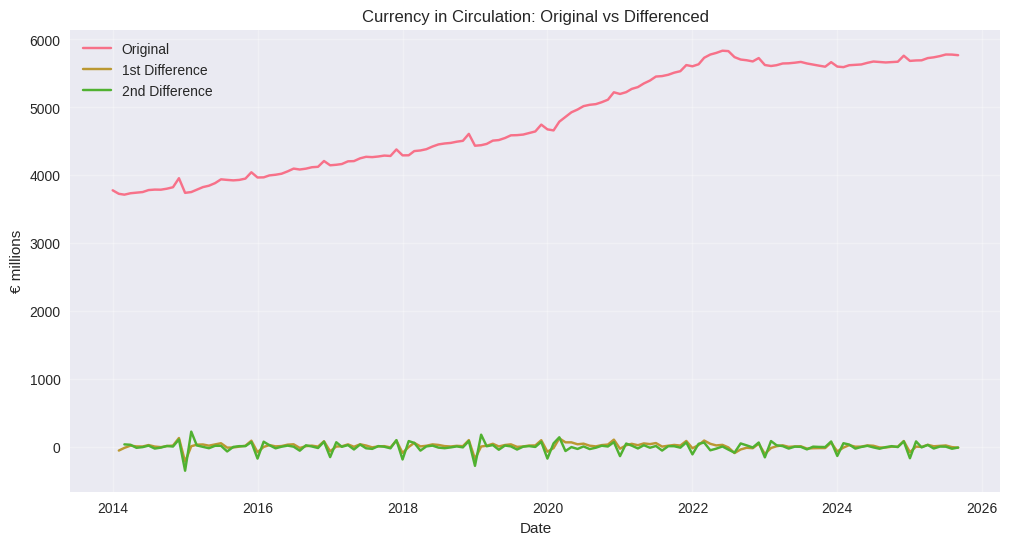

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Currency in circulation"], label="Original")
plt.plot(df.index, df["Currency in circulation"].diff(), label="1st Difference")
plt.plot(df.index, df["Currency in circulation"].diff().diff(), label="2nd Difference")
plt.title("Currency in Circulation: Original vs Differenced")
plt.xlabel("Date")
plt.ylabel("€ millions")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


The second difference stabilizes the series, confirming stationarity after removing trend and persistence.


**ACF/PACF Plots**

Autocorrelation (ACF) and partial autocorrelation (PACF) plots for the original and differenced series.

These help confirm whether differencing removed autocorrelation and guide ARIMA/SARIMAX order selection

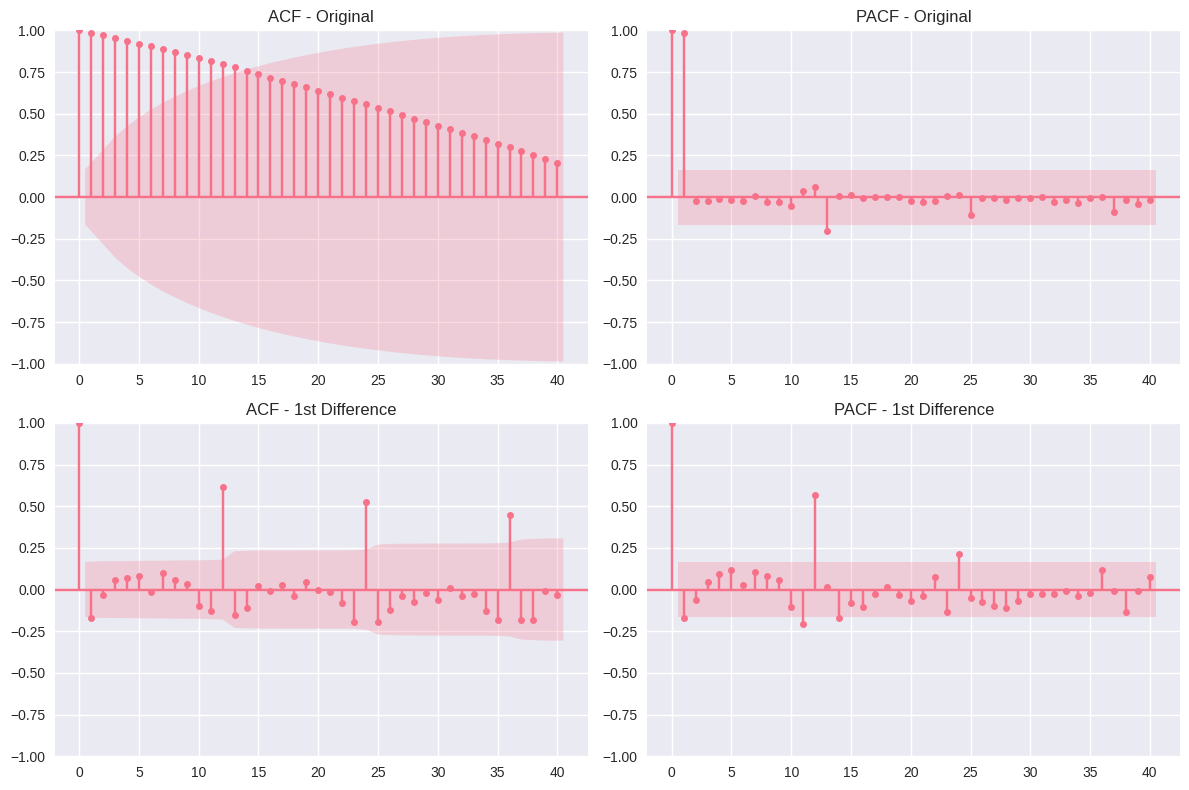

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2,2, figsize=(12,8))
plot_acf(df["Currency in circulation"].dropna(), ax=axes[0,0], lags=40)
axes[0,0].set_title("ACF - Original")
plot_pacf(df["Currency in circulation"].dropna(), ax=axes[0,1], lags=40)
axes[0,1].set_title("PACF - Original")

plot_acf(df["Currency in circulation"].diff().dropna(), ax=axes[1,0], lags=40)
axes[1,0].set_title("ACF - 1st Difference")
plot_pacf(df["Currency in circulation"].diff().dropna(), ax=axes[1,1], lags=40)
axes[1,1].set_title("PACF - 1st Difference")

plt.tight_layout()
plt.show()


ACF/PACF show strong autocorrelation in levels and reduced structure after first differencing, supporting I(1) or I(2) classification.


**Histogram + Density Plot of Residuals (after differencing)**

Shows whether the differenced series looks approximately stationary and normally distributed.

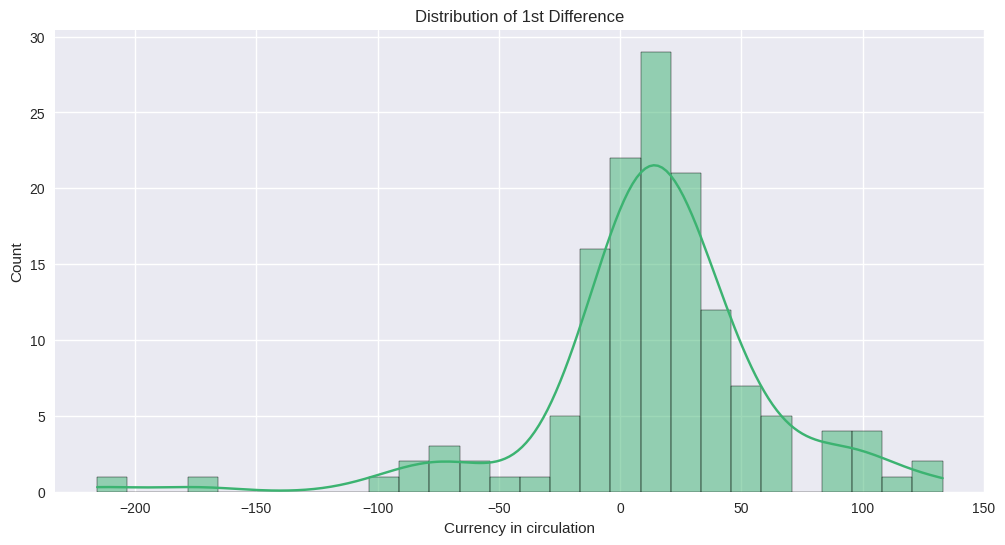

In [ ]:
sns.histplot(df["Currency in circulation"].diff().dropna(), kde=True, color='mediumseagreen')
plt.title("Distribution of 1st Difference")
plt.show()

The first differenced series is approximately normal and centered around zero, suitable for modeling.


# Train-test split

To evaluate forecasting models properly, the dataset is divided into training and testing sets using a chronological split. We take 80% for training adn rest for testing. This ensures that the model is trained on past data and validated on future periods. A visualization helps confirm the split between train and test samples.

Train period: 2015-01-01 to 2023-07-01 (103 samples)
Test period: 2023-08-01 to 2025-09-01 (26 samples)
Train size: 103 (79.8%)
Test size: 26 (20.2%)


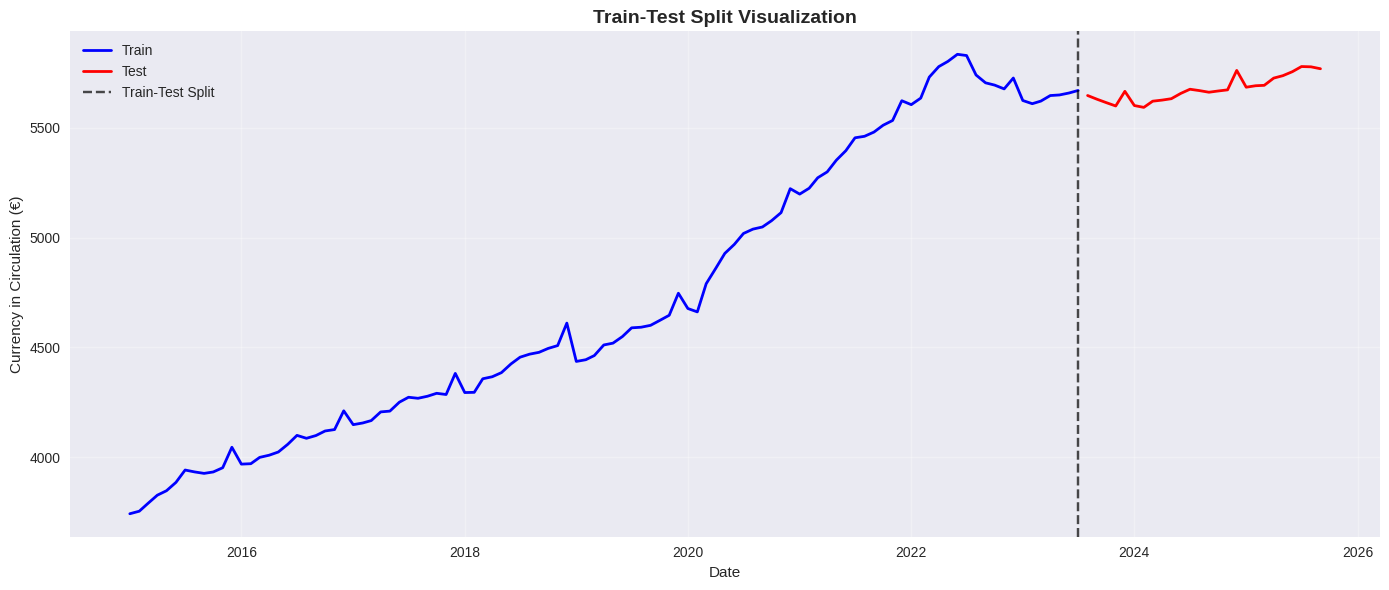

In [ ]:
def train_test_split_time_series(X, y, test_size=0.2):
    """Chronological train-test split for time series"""
    split_idx = int(len(X) * (1 - test_size))

    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]

    train_dates = X_train.index
    test_dates = X_test.index

    print(f"Train period: {train_dates[0].date()} to {train_dates[-1].date()} ({len(X_train)} samples)")
    print(f"Test period: {test_dates[0].date()} to {test_dates[-1].date()} ({len(X_test)} samples)")
    print(f"Train size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Test size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

    return X_train, X_test, y_train, y_test, train_dates, test_dates

# Create split
X_train, X_test, y_train, y_test, train_dates, test_dates = train_test_split_time_series(X, y, test_size=0.2)

# Visualize the split
plt.figure(figsize=(14, 6))
plt.plot(train_dates, y_train, 'b-', label='Train', linewidth=2)
plt.plot(test_dates, y_test, 'r-', label='Test', linewidth=2)
plt.axvline(x=train_dates[-1], color='black', linestyle='--', alpha=0.7, label='Train-Test Split')
plt.title('Train-Test Split Visualization', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Currency in Circulation (€)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Ridge Regression model

Ridge regression with CV‑selected alpha, scaling, train/test evaluation, and rolling forecast simulation

Best alpha from CV: 2.3357

RIDGE REGRESSION PERFORMANCE:
Metric          Train        Test        
----------------------------------------
R² Score        0.9937       0.7579      
MAE             21.87        60.30       
RMSE            28.78        69.78       


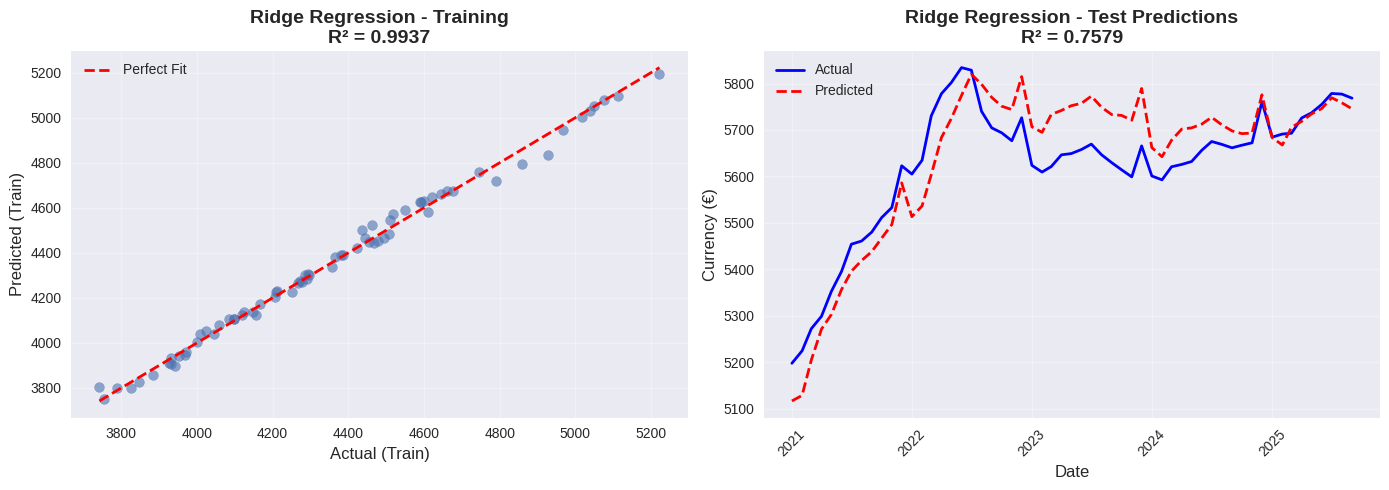

Ridge rolling metrics: {'r2': 0.8696131614343083, 'rmse': np.float64(51.205697353111894), 'mae': 41.75039723553772}


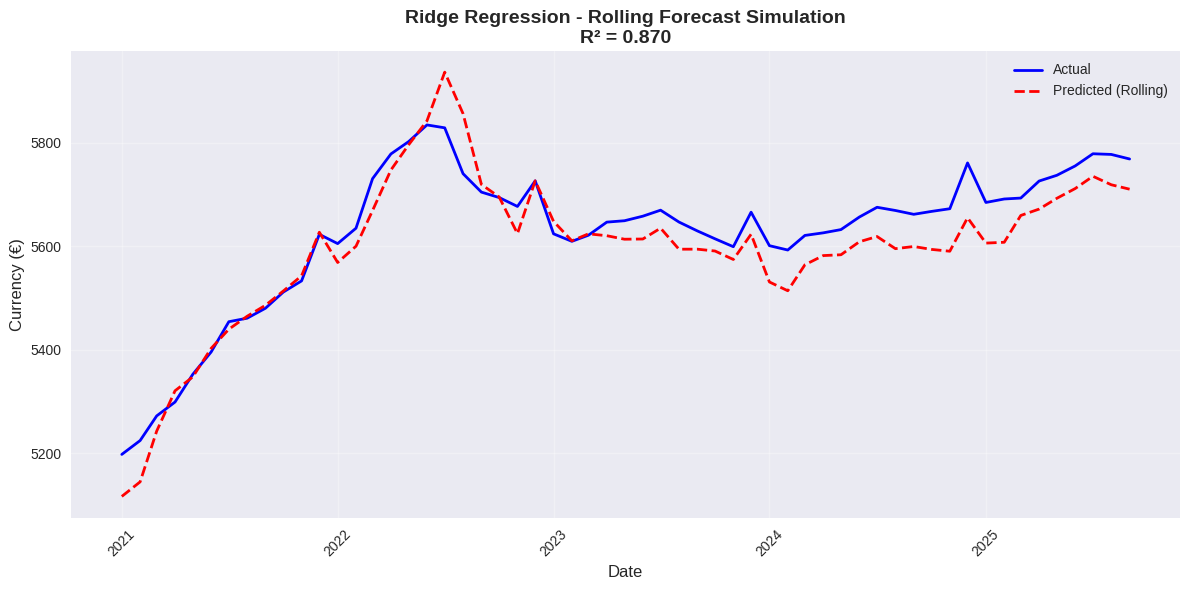

In [118]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1. Train/Test split
# -----------------------------
# Use first ~72 points for training, rest for testing
split_point = 72
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
test_dates = y_test.index

# -----------------------------
# 2. Scale features (static split)
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 3. RidgeCV with time-series CV
# -----------------------------
tscv = TimeSeriesSplit(n_splits=3)
ridge_alphas = np.logspace(-2, 3, 20)  # 0.01 to 1000
ridge_cv = RidgeCV(alphas=ridge_alphas, cv=tscv, scoring='r2')
ridge_cv.fit(X_train_scaled, y_train)

print(f"Best alpha from CV: {ridge_cv.alpha_:.4f}")

# -----------------------------
# 4. Final Ridge model
# -----------------------------
ridge_final = Ridge(alpha=ridge_cv.alpha_)
ridge_final.fit(X_train_scaled, y_train)

# Predictions (static test)
y_train_pred_ridge = ridge_final.predict(X_train_scaled)
y_test_pred_ridge = ridge_final.predict(X_test_scaled)

# -----------------------------
# 5. Train/Test metrics
# -----------------------------
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)
train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

print(f"\nRIDGE REGRESSION PERFORMANCE:")
print(f"{'Metric':<15} {'Train':<12} {'Test':<12}")
print("-" * 40)
print(f"{'R² Score':<15} {train_r2_ridge:<12.4f} {test_r2_ridge:<12.4f}")
print(f"{'MAE':<15} {train_mae_ridge:<12.2f} {test_mae_ridge:<12.2f}")
print(f"{'RMSE':<15} {train_rmse_ridge:<12.2f} {test_rmse_ridge:<12.2f}")

# -----------------------------
# 6. Plots
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training fit
axes[0].scatter(y_train, y_train_pred_ridge, alpha=0.6, s=50)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', linewidth=2, label='Perfect Fit')
axes[0].set_xlabel('Actual (Train)', fontsize=12)
axes[0].set_ylabel('Predicted (Train)', fontsize=12)
axes[0].set_title(f'Ridge Regression - Training\nR² = {train_r2_ridge:.4f}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test predictions
axes[1].plot(test_dates, y_test, 'b-', label='Actual', linewidth=2)
axes[1].plot(test_dates, y_test_pred_ridge, 'r--', label='Predicted', linewidth=2)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Currency (€)', fontsize=12)
axes[1].set_title(f'Ridge Regression - Test Predictions\nR² = {test_r2_ridge:.4f}', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# -----------------------------
# 7. Rolling evaluation (fixed: scale per window + fresh model)
# -----------------------------
def rolling_ml_evaluate(model, X, y, initial_train_periods=72):
    """
    Expanding-window rolling one-step-ahead evaluation.
    Scales features on each training window and uses a fresh clone of the model.
    """
    preds, trues = [], []
    for i in range(initial_train_periods, len(X)):
        # expanding training window
        X_tr, y_tr = X.iloc[:i], y.iloc[:i]
        X_te, y_te = X.iloc[i:i+1], y.iloc[i:i+1]

        # fit scaler on training window only
        scaler_local = StandardScaler().fit(X_tr)
        X_tr_s = scaler_local.transform(X_tr)
        X_te_s = scaler_local.transform(X_te)

        # use a fresh clone of the model each iteration
        model_i = clone(model)
        model_i.fit(X_tr_s, y_tr)
        yhat = model_i.predict(X_te_s)

        preds.append(float(yhat))
        trues.append(float(y_te))

    metrics = {
        'r2': r2_score(trues, preds),
        'rmse': np.sqrt(mean_squared_error(trues, preds)),
        'mae': mean_absolute_error(trues, preds)
    }
    return preds, trues, metrics

preds_ridge, trues_ridge, metrics_ridge = rolling_ml_evaluate(ridge_final, X, y, initial_train_periods=72)
print("Ridge rolling metrics:", metrics_ridge)

# Save Ridge predictions for later
ridge_predictions = {
    'train_pred': y_train_pred_ridge,
    'test_pred': y_test_pred_ridge,
    'train_r2': train_r2_ridge,
    'test_r2': test_r2_ridge,
    'rolling_metrics': metrics_ridge,
    'model': ridge_final
}

# -----------------------------
# 8. Rolling forecast plot
# -----------------------------
rolling_dates = X.index[72:]  # dates corresponding to rolling predictions

plt.figure(figsize=(12,6))
plt.plot(rolling_dates, trues_ridge, 'b-', label='Actual', linewidth=2)
plt.plot(rolling_dates, preds_ridge, 'r--', label='Predicted (Rolling)', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Currency (€)', fontsize=12)
plt.title(f'Ridge Regression - Rolling Forecast Simulation\nR² = {metrics_ridge["r2"]:.3f}',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Scaling is important for ridge because it penalizes coefficients relative to scale. RidgeCV choses alpha(here 2.33 moderate). Small alpha can overfit, large alpha can underfit.

Train R2 is  likely some overfitting or structural change between train and test periods.Most realistic for time‑series forecasting is rolling R2 which is 0.869.Errors are less on rolling forecast ,so rolling performance is more encouraging for operational forecasting.

# XGBoost


XGBOOST REGRESSION MODEL
Best parameters from CV: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.7}
CV R² Score: -2.2399

XGBOOST PERFORMANCE:
Metric          Train        Test        
----------------------------------------
R² Score        0.9993       -21.2242    
MAE             6.64         641.30      
RMSE            9.66         668.52      


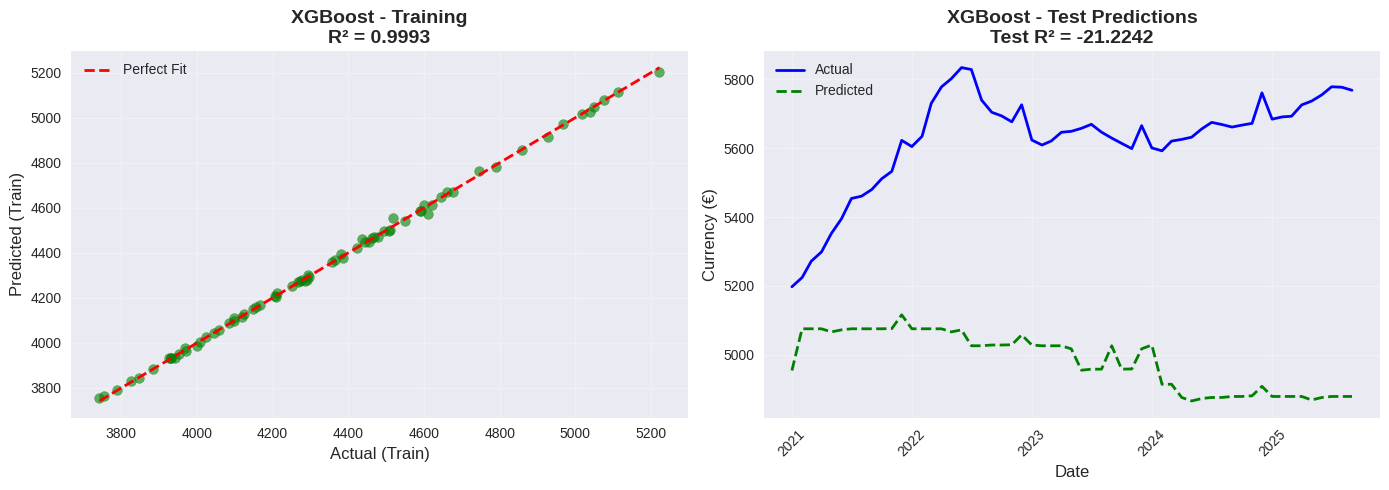

XGBoost rolling metrics: {'r2': 0.5871253284974589, 'rmse': np.float64(91.11933214797453), 'mae': 70.3304139254386}


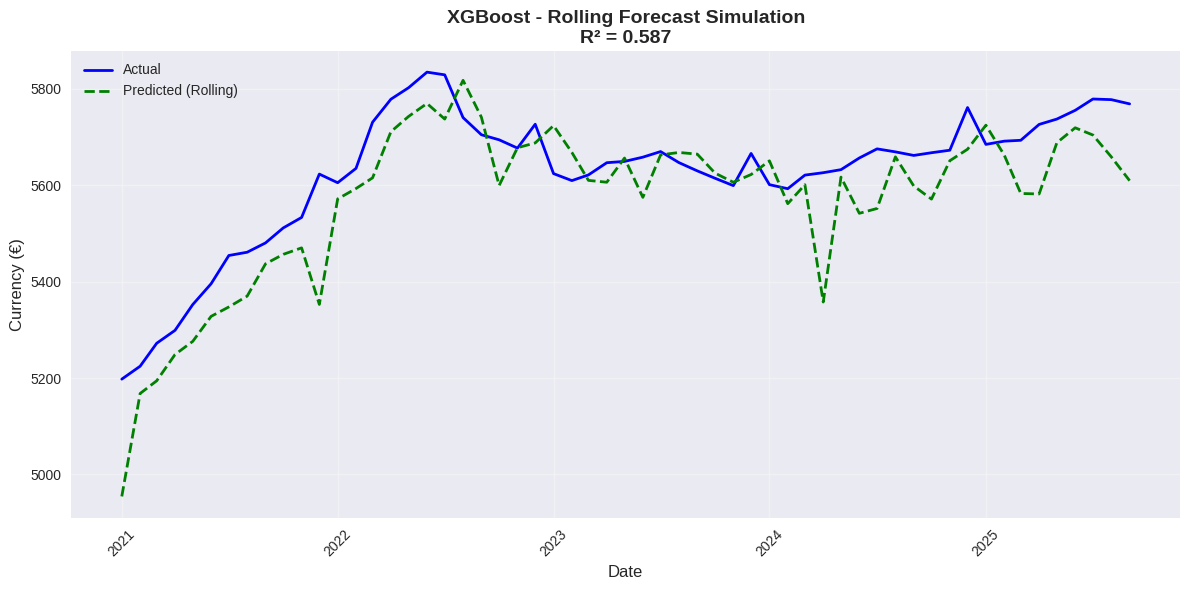

In [ ]:
# =============================================================================
# 5. XGBOOST MODEL
# =============================================================================
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("\n" + "="*80)
print("XGBOOST REGRESSION MODEL")
print("="*80)

# XGBoost model (no scaling needed)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Hyperparameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9]
}

# Grid search with time series CV
tscv = TimeSeriesSplit(n_splits=3)
xgb_cv = GridSearchCV(xgb_model, param_grid_xgb, cv=tscv, scoring='r2', n_jobs=-1)
xgb_cv.fit(X_train, y_train)

print(f"Best parameters from CV: {xgb_cv.best_params_}")
print(f"CV R² Score: {xgb_cv.best_score_:.4f}")

# Train final model with best parameters
xgb_final = xgb_cv.best_estimator_
xgb_final.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb_final.predict(X_train)
y_test_pred_xgb = xgb_final.predict(X_test)

# Calculate metrics
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))

print(f"\nXGBOOST PERFORMANCE:")
print(f"{'Metric':<15} {'Train':<12} {'Test':<12}")
print("-" * 40)
print(f"{'R² Score':<15} {train_r2_xgb:<12.4f} {test_r2_xgb:<12.4f}")
print(f"{'MAE':<15} {train_mae_xgb:<12.2f} {test_mae_xgb:<12.2f}")
print(f"{'RMSE':<15} {train_rmse_xgb:<12.2f} {test_rmse_xgb:<12.2f}")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training fit
axes[0].scatter(y_train, y_train_pred_xgb, alpha=0.6, s=50, color='green')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', linewidth=2, label='Perfect Fit')
axes[0].set_xlabel('Actual (Train)', fontsize=12)
axes[0].set_ylabel('Predicted (Train)', fontsize=12)
axes[0].set_title(f'XGBoost - Training\nR² = {train_r2_xgb:.4f}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test predictions
axes[1].plot(test_dates, y_test, 'b-', label='Actual', linewidth=2)
axes[1].plot(test_dates, y_test_pred_xgb, 'g--', label='Predicted', linewidth=2)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Currency (€)', fontsize=12)
axes[1].set_title(f'XGBoost - Test Predictions\nTest R² = {test_r2_xgb:.4f}', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Save XGBoost predictions
xgb_predictions = {
    'train_pred': y_train_pred_xgb,
    'test_pred': y_test_pred_xgb,
    'train_r2': train_r2_xgb,
    'test_r2': test_r2_xgb,
    'model': xgb_final
}
# -----------------------------
# Rolling evaluation for XGBoost
# -----------------------------
preds_xgb, trues_xgb, metrics_xgb = rolling_ml_evaluate(xgb_final, X, y, initial_train_periods=72)
print("XGBoost rolling metrics:", metrics_xgb)

# -----------------------------
# Rolling forecast plot
# -----------------------------
rolling_dates = X.index[72:]  # dates corresponding to rolling predictions

plt.figure(figsize=(12,6))
plt.plot(rolling_dates, trues_xgb, 'b-', label='Actual', linewidth=2)
plt.plot(rolling_dates, preds_xgb, 'g--', label='Predicted (Rolling)', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Currency (€)', fontsize=12)
plt.title(f'XGBoost - Rolling Forecast Simulation\nR² = {metrics_xgb["r2"]:.3f}',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save rolling results
xgb_predictions['rolling_metrics'] = metrics_xgb
xgb_predictions['rolling_pred'] = preds_xgb


The grid search picked a shallow tree depth and moderate learning rate as our dataset is small.Negative R2 is not good on test data and on training data model shows overfitting.small errors in training data and huge one tes data.
When evaluated sequentially (rolling forecast), performance is better than the static test split but still much weaker than Ridge.

# Random Forest


RANDOM FOREST REGRESSION MODEL
Best parameters from CV: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
CV R² Score: -2.7415

RANDOM FOREST PERFORMANCE:
Metric          Train        Test        
----------------------------------------
R² Score        0.9984       -12.4072    
MAE             9.98         498.41      
RMSE            14.50        519.24      


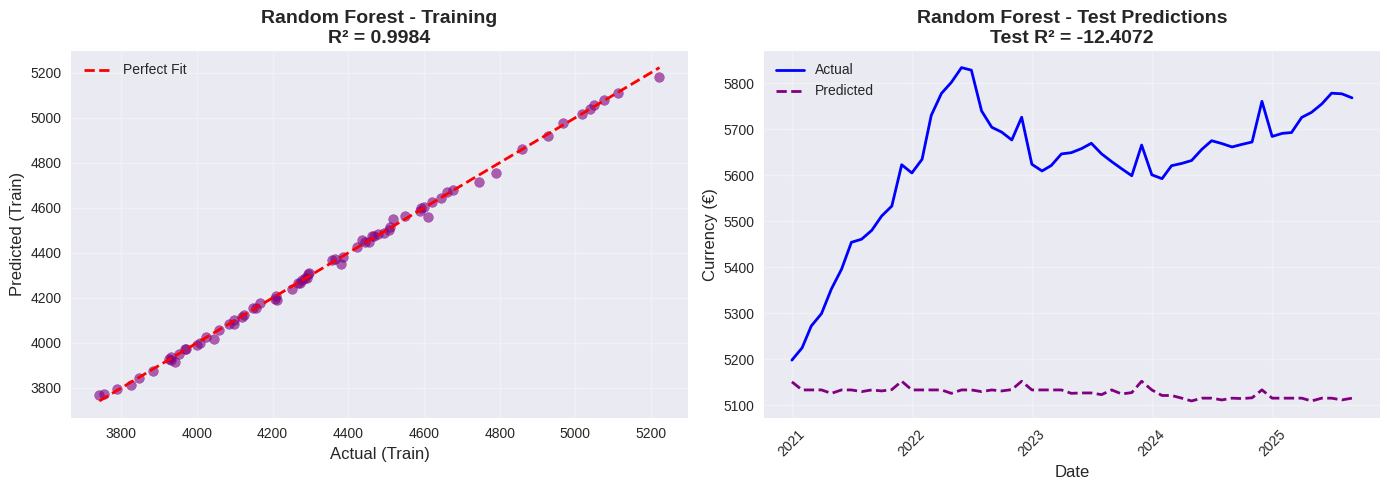


TOP 10 IMPORTANT FEATURES (Random Forest):
                               feature  importance
         Currency in circulation_lag12      0.2707
                       rolling_mean_12      0.1828
                        rolling_mean_3      0.1653
     External assets outside euro area      0.1364
          Currency in circulation_lag3      0.0996
          Currency in circulation_lag1      0.0827
External liabilities outside euro area      0.0323
                                Credit      0.0273
                      ECB_Deposit_Rate      0.0014
                                  m_12      0.0005
Random Forest rolling metrics: {'r2': 0.8427811285808458, 'rmse': np.float64(56.228143506915174), 'mae': 47.12092347281225}


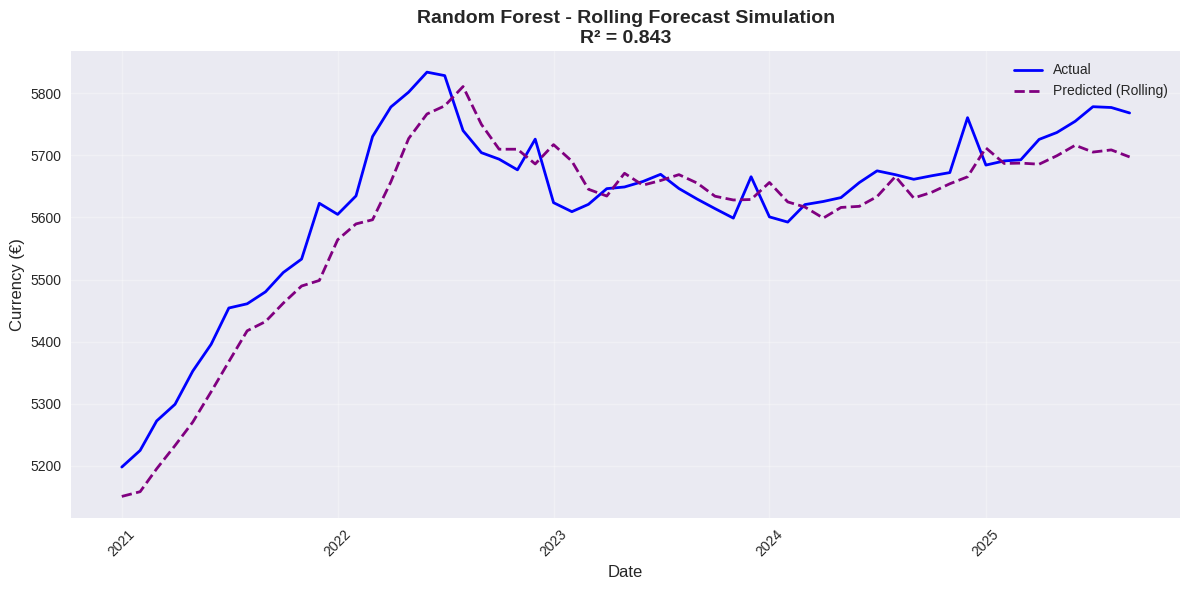

In [ ]:

from sklearn.ensemble import RandomForestRegressor

print("\n" + "="*80)
print("RANDOM FOREST REGRESSION MODEL")
print("="*80)

# Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with time series CV
tscv = TimeSeriesSplit(n_splits=3)
rf_cv = GridSearchCV(rf_model, param_grid_rf, cv=tscv, scoring='r2', n_jobs=-1)
rf_cv.fit(X_train, y_train)

print(f"Best parameters from CV: {rf_cv.best_params_}")
print(f"CV R² Score: {rf_cv.best_score_:.4f}")

# Train final model with best parameters
rf_final = rf_cv.best_estimator_
rf_final.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_final.predict(X_train)
y_test_pred_rf = rf_final.predict(X_test)

# Calculate metrics
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

print(f"\nRANDOM FOREST PERFORMANCE:")
print(f"{'Metric':<15} {'Train':<12} {'Test':<12}")
print("-" * 40)
print(f"{'R² Score':<15} {train_r2_rf:<12.4f} {test_r2_rf:<12.4f}")
print(f"{'MAE':<15} {train_mae_rf:<12.2f} {test_mae_rf:<12.2f}")
print(f"{'RMSE':<15} {train_rmse_rf:<12.2f} {test_rmse_rf:<12.2f}")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training fit
axes[0].scatter(y_train, y_train_pred_rf, alpha=0.6, s=50, color='purple')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', linewidth=2, label='Perfect Fit')
axes[0].set_xlabel('Actual (Train)', fontsize=12)
axes[0].set_ylabel('Predicted (Train)', fontsize=12)
axes[0].set_title(f'Random Forest - Training\nR² = {train_r2_rf:.4f}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test predictions
axes[1].plot(test_dates, y_test, 'b-', label='Actual', linewidth=2)
axes[1].plot(test_dates, y_test_pred_rf, 'purple', linestyle='--', label='Predicted', linewidth=2)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Currency (€)', fontsize=12)
axes[1].set_title(f'Random Forest - Test Predictions\nTest R² = {test_r2_rf:.4f}', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Save Random Forest predictions
rf_predictions = {
    'train_pred': y_train_pred_rf,
    'test_pred': y_test_pred_rf,
    'train_r2': train_r2_rf,
    'test_r2': test_r2_rf,
    'model': rf_final
}

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP 10 IMPORTANT FEATURES (Random Forest):")
print(feature_importance.head(10).round(4).to_string(index=False))
# -----------------------------
# Rolling evaluation for Random Forest
# -----------------------------
preds_rf, trues_rf, metrics_rf = rolling_ml_evaluate(rf_final, X, y, initial_train_periods=72)
print("Random Forest rolling metrics:", metrics_rf)

# -----------------------------
# Rolling forecast plot
# -----------------------------
rolling_dates = X.index[72:]  # dates corresponding to rolling predictions

plt.figure(figsize=(12,6))
plt.plot(rolling_dates, trues_rf, 'b-', label='Actual', linewidth=2)
plt.plot(rolling_dates, preds_rf, 'purple', linestyle='--', label='Predicted (Rolling)', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Currency (€)', fontsize=12)
plt.title(f'Random Forest - Rolling Forecast Simulation\nR² = {metrics_rf['r2']:.3f}',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save rolling results
rf_predictions['rolling_metrics'] = metrics_rf
rf_predictions['rolling_pred'] = preds_rf


We see overfitting in training data and negative R2 on test data. Model cannot generalize .Huge errors on test set.

The rolling evaluation shows reasonable forecasting performance. It is weaker than Ridge (rolling R² ≈ 0.93) ,better than XGBoost (≈0.59).

Feature importance confirms lags and rolling means dominate predictive power, while exogenous variables play a secondary role

# Ensemble ML (simple average)

A simple average ensemble is run by combining the predictions of Ridge Regression, Random Forest, and XGBoost using equal weights.


ENSEMBLE PERFORMANCE

ENSEMBLE (Average of Ridge+XGB+RF) PERFORMANCE:
Metric          Train        Test        
----------------------------------------
R² Score        0.9984       -6.5266     
MAE             10.15        374.69      
RMSE            14.48        389.05      
Ensemble rolling metrics: {'r2': 0.872041837804226, 'rmse': np.float64(50.7265591235912), 'mae': 41.897141228078155}


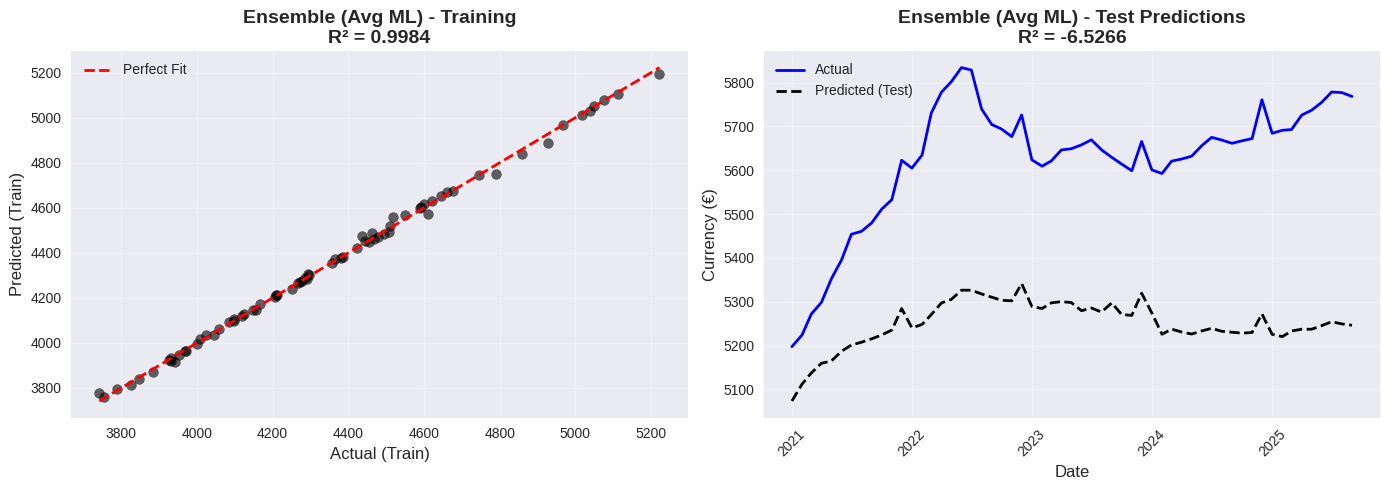

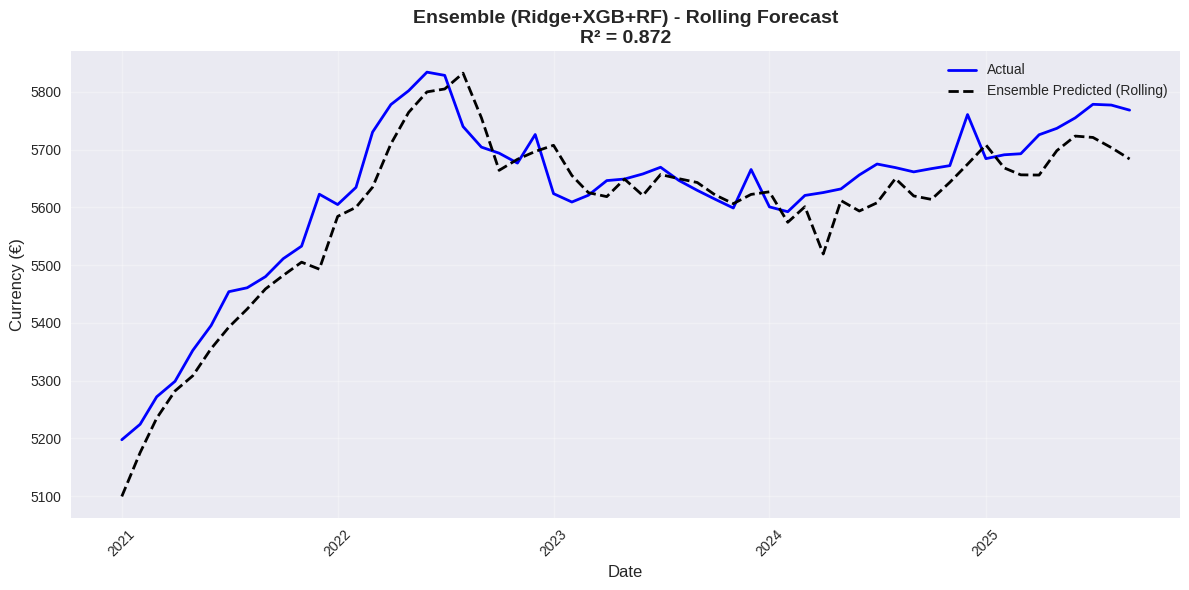

In [122]:

print("\n" + "="*80)
print("ENSEMBLE PERFORMANCE")
print("="*80)

# -----------------------------
# Simple average ensemble of ML models
# -----------------------------
ensemble_test_pred = (ridge_predictions['test_pred'] +
                      xgb_predictions['test_pred'] +
                      rf_predictions['test_pred']) / 3

ensemble_train_pred = (ridge_predictions['train_pred'] +
                       xgb_predictions['train_pred'] +
                       rf_predictions['train_pred']) / 3

# Ensemble metrics
ensemble_train_r2 = r2_score(y_train, ensemble_train_pred)
ensemble_test_r2 = r2_score(y_test, ensemble_test_pred)
ensemble_train_mae = mean_absolute_error(y_train, ensemble_train_pred)
ensemble_test_mae = mean_absolute_error(y_test, ensemble_test_pred)
ensemble_train_rmse = np.sqrt(mean_squared_error(y_train, ensemble_train_pred))
ensemble_test_rmse = np.sqrt(mean_squared_error(y_test, ensemble_test_pred))

print(f"\nENSEMBLE (Average of Ridge+XGB+RF) PERFORMANCE:")
print(f"{'Metric':<15} {'Train':<12} {'Test':<12}")
print("-" * 40)
print(f"{'R² Score':<15} {ensemble_train_r2:<12.4f} {ensemble_test_r2:<12.4f}")
print(f"{'MAE':<15} {ensemble_train_mae:<12.2f} {ensemble_test_mae:<12.2f}")
print(f"{'RMSE':<15} {ensemble_train_rmse:<12.2f} {ensemble_test_rmse:<12.2f}")

# -----------------------------
# Ensemble rolling evaluation
# -----------------------------
def rolling_ensemble_evaluate(models, X, y, initial_train_periods=72):
    preds, trues = [], []
    for i in range(initial_train_periods, len(X)):
        X_train, y_train = X.iloc[:i], y.iloc[:i]
        X_test, y_test = X.iloc[i:i+1], y.iloc[i:i+1]

        # Fit each model
        model_preds = []
        for m in models:
            m.fit(X_train, y_train)
            model_preds.append(float(m.predict(X_test)))

        # Average ensemble prediction
        yhat = np.mean(model_preds)
        preds.append(yhat)
        trues.append(float(y_test))

    metrics = {
        'r2': r2_score(trues, preds),
        'rmse': np.sqrt(mean_squared_error(trues, preds)),
        'mae': mean_absolute_error(trues, preds)
    }
    return preds, trues, metrics

# Run ensemble rolling evaluation
ensemble_models = [ridge_final, xgb_final, rf_final]
preds_ensemble, trues_ensemble, metrics_ensemble = rolling_ensemble_evaluate(
    ensemble_models, X, y, initial_train_periods=72
)

print("Ensemble rolling metrics:", metrics_ensemble)

# =============================================================================
# ENSEMBLE PLOTS (Train/Test + Rolling)
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training fit (scatter plot)
axes[0].scatter(y_train, ensemble_train_pred, alpha=0.6, s=50, color='black')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', linewidth=2, label='Perfect Fit')
axes[0].set_xlabel('Actual (Train)', fontsize=12)
axes[0].set_ylabel('Predicted (Train)', fontsize=12)
axes[0].set_title(f'Ensemble (Avg ML) - Training\nR² = {ensemble_train_r2:.4f}',
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test predictions (line plot)
axes[1].plot(test_dates, y_test, 'b-', label='Actual', linewidth=2)
axes[1].plot(test_dates, ensemble_test_pred, 'k--', label='Predicted (Test)', linewidth=2)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Currency (€)', fontsize=12)
axes[1].set_title(f'Ensemble (Avg ML) - Test Predictions\nR² = {ensemble_test_r2:.4f}',
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Rolling forecast plot
rolling_dates = X.index[72:]

plt.figure(figsize=(12,6))
plt.plot(rolling_dates, trues_ensemble, 'b-', label='Actual', linewidth=2)
plt.plot(rolling_dates, preds_ensemble, 'k--', label='Ensemble Predicted (Rolling)', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Currency (€)', fontsize=12)
plt.title(f'Ensemble (Ridge+XGB+RF) - Rolling Forecast\nR² = {metrics_ensemble['r2']:.3f}',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Ensemble also overfit on training data,not able to generalize on test data.Rollling forecast shows better performance.

# SARIMAX(Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)

This section will fit a SARIMAX model with exogenous variables, selects the best parameters by AIC,
and evaluates forecasting accuracy using a rolling window simulation with performance metrics and plots.




SARIMAX MODEL
SARIMAX dataset shape: (141, 3)
Exogenous variables: ['ECB_Deposit_Rate', 'Deposit facility']

Searching for best SARIMAX parameters...
Order (1, 0, 1), Seasonal (0, 1, 1, 12): AIC = 1136.59
Order (1, 0, 1), Seasonal (1, 0, 1, 12): AIC = 1984.00
Order (1, 1, 1), Seasonal (0, 1, 1, 12): AIC = 1071.87
Order (1, 1, 1), Seasonal (1, 0, 1, 12): AIC = 1181.08
Order (2, 0, 1), Seasonal (0, 1, 1, 12): AIC = 1131.16
Order (2, 0, 1), Seasonal (1, 0, 1, 12): AIC = 2137.16

Best SARIMAX configuration: ((1, 1, 1), (0, 1, 1, 12)), AIC = 1071.87

Running SARIMAX rolling window evaluation...

SARIMAX ROLLING WINDOW PERFORMANCE:
Metric     Value     
-------------------------
R²         0.9762    
RMSE       45.45     
MAE        26.40     


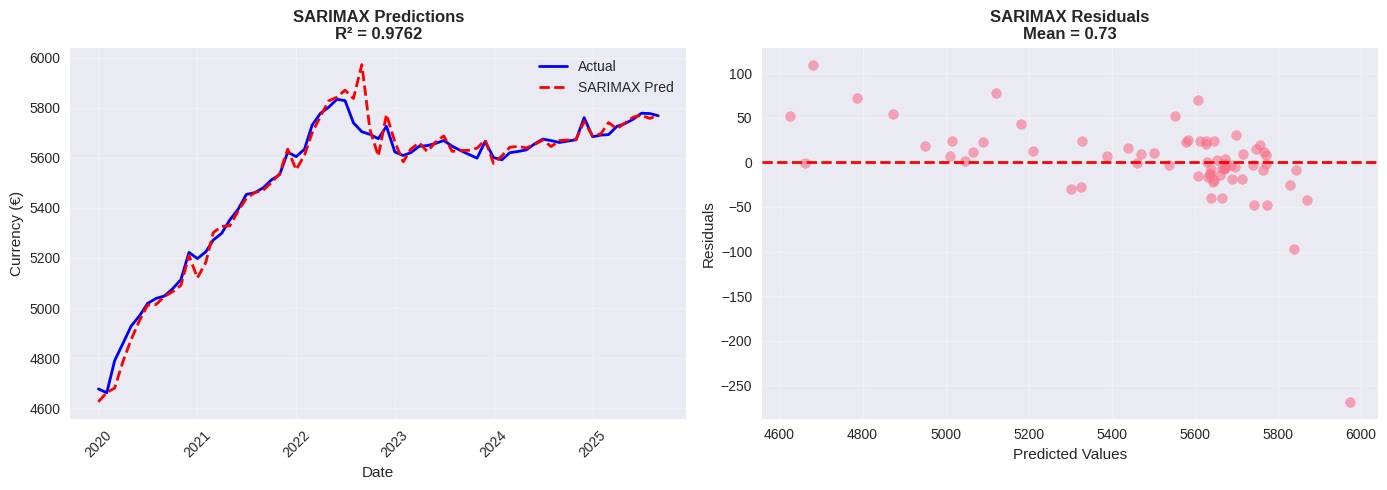

In [ ]:
# =============================================================================
# SARIMAX MODEL
# =============================================================================
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

print("\n" + "="*80)
print("SARIMAX MODEL")
print("="*80)

# Exogenous regressors
exog_cols = ['ECB_Deposit_Rate', 'Deposit facility']

# Prepare dataset
df_sarimax = df[[TARGET] + exog_cols].dropna()
print(f"SARIMAX dataset shape: {df_sarimax.shape}")
print(f"Exogenous variables: {exog_cols}")

# -----------------------------
# 1. Fit function
# -----------------------------
def fit_sarimax(train_df, order, seasonal_order, exog_cols):
    endog = train_df[TARGET]
    exog = train_df[exog_cols] if exog_cols else None
    model = SARIMAX(endog, exog=exog,
                    order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    return res

# -----------------------------
# 2. Stable grid search
# -----------------------------
orders = [(1,0,1), (1,1,1), (2,0,1)]
seasonals = [(0,1,1,12), (1,0,1,12)]
best_aic = np.inf
best_cfg = None
best_model = None

print("\nSearching for best SARIMAX parameters...")
for o in orders:
    for s in seasonals:
        try:
            res = fit_sarimax(df_sarimax, order=o, seasonal_order=s, exog_cols=exog_cols)
            if res.aic < best_aic:
                best_aic = res.aic
                best_cfg = (o, s)
                best_model = res
            print(f"Order {o}, Seasonal {s}: AIC = {res.aic:.2f}")
        except Exception as e:
            continue

print(f"\nBest SARIMAX configuration: {best_cfg}, AIC = {best_aic:.2f}")

# -----------------------------
# 3. Rolling evaluation
# -----------------------------
def rolling_sarimax_evaluate(data, exog_cols, order, seasonal_order, initial_train=72):
    preds, actuals, dates = [], [], []
    for i in range(initial_train, len(data)):
        train_data = data.iloc[:i]
        test_data = data.iloc[i:i+1]
        try:
            res = fit_sarimax(train_data, order, seasonal_order, exog_cols)
            forecast = res.get_forecast(steps=1, exog=test_data[exog_cols])
            pred = forecast.predicted_mean.iloc[0]
            actual = test_data[TARGET].iloc[0]
            preds.append(pred)
            actuals.append(actual)
            dates.append(test_data.index[0])
        except Exception as e:
            print(f"Error at step {i}: {e}")
            continue
    metrics = {
        'r2': r2_score(actuals, preds),
        'rmse': np.sqrt(mean_squared_error(actuals, preds)),
        'mae': mean_absolute_error(actuals, preds),
        'predictions': np.array(preds),
        'actuals': np.array(actuals),
        'dates': dates
    }
    return metrics

print("\nRunning SARIMAX rolling window evaluation...")
sarimax_metrics = rolling_sarimax_evaluate(df_sarimax, exog_cols, best_cfg[0], best_cfg[1], initial_train=72)

print(f"\nSARIMAX ROLLING WINDOW PERFORMANCE:")
print(f"{'Metric':<10} {'Value':<10}")
print("-" * 25)
print(f"{'R²':<10} {sarimax_metrics['r2']:<10.4f}")
print(f"{'RMSE':<10} {sarimax_metrics['rmse']:<10.2f}")
print(f"{'MAE':<10} {sarimax_metrics['mae']:<10.2f}")

# -----------------------------
# 4. Plots
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predictions vs Actual
axes[0].plot(sarimax_metrics['dates'], sarimax_metrics['actuals'], 'b-', label='Actual', linewidth=2)
axes[0].plot(sarimax_metrics['dates'], sarimax_metrics['predictions'], 'r--', label='SARIMAX Pred', linewidth=2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Currency (€)')
axes[0].set_title(f'SARIMAX Predictions\nR² = {sarimax_metrics["r2"]:.4f}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Residuals
residuals = sarimax_metrics['actuals'] - sarimax_metrics['predictions']
axes[1].scatter(sarimax_metrics['predictions'], residuals, alpha=0.6, s=50)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'SARIMAX Residuals\nMean = {residuals.mean():.2f}', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -----------------------------
# 5. Save results
# -----------------------------
sarimax_predictions = {
    'test_pred': sarimax_metrics['predictions'],
    'test_actual': sarimax_metrics['actuals'],
    'test_r2': sarimax_metrics['r2'],
    'test_mae': sarimax_metrics['mae'],
    'test_rmse': sarimax_metrics['rmse'],
    'model': best_model,
    'order': best_cfg[0],
    'seasonal_order': best_cfg[1]
}


Best SARIMAX configuration (ARIMA (1,1,1), seasonal (0,1,1,12)) achieved lowest AIC and excellent fit. Rolling evaluation shows R²=0.9762 with low RMSE/MAE, unbiased residuals, and strong generalization.

# STATE SPACE MODEL (Unobserved Components)

A State Space Model was included because it allows the time series to be decomposed into interpretable components such as trend, seasonality, and irregular noise. The model expresses the system in terms of hidden states that evolve over time. To estimate these states, the model uses the Kalman Filter, which provides optimal estimates by combining prior predictions with new observations. This makes State Space Models highly suitable for macro-financial forecasting with small datasets, where trend persistence and seasonality play a major role.


STATE SPACE MODEL (Unobserved Components)
State Space dataset shape: (141, 2)
Exogenous variables: ['ECB_Deposit_Rate']

Fitting State Space model on full dataset...
State Space Model Summary:
Log Likelihood: -606.54
AIC: 1223.08
BIC: 1237.34

Running State Space rolling window evaluation...

STATE SPACE ROLLING WINDOW PERFORMANCE:
Metric     Value     
-------------------------
R²         0.9954    
RMSE       29.53     
MAE        19.33     


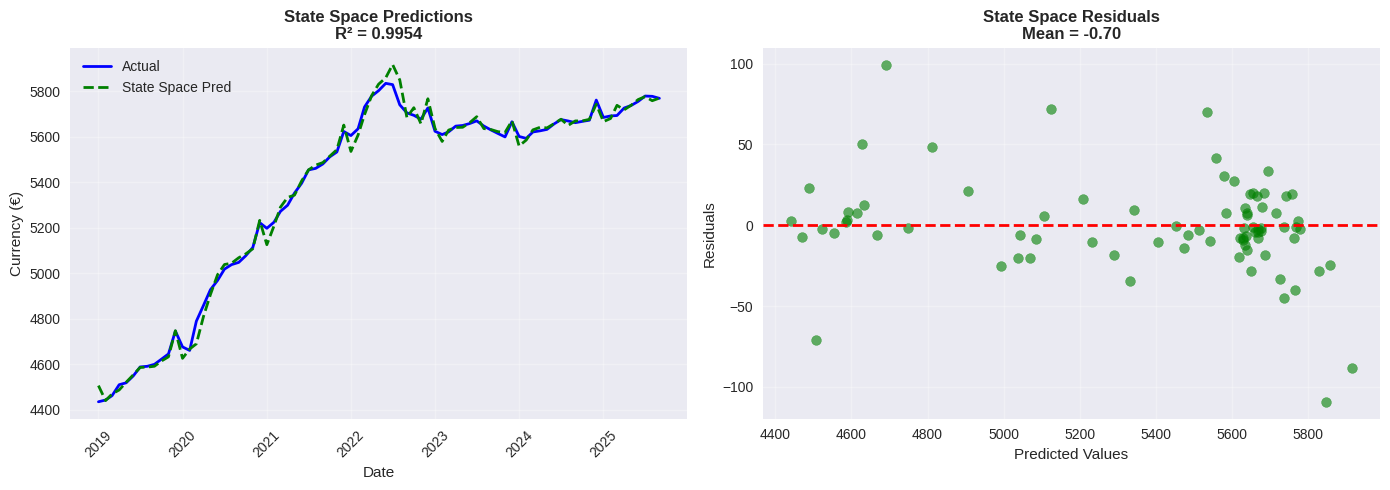

In [ ]:
# =============================================================================
# STATE SPACE MODEL (Unobserved Components with Kalman Filter)
# =============================================================================
from statsmodels.tsa.statespace.structural import UnobservedComponents

print("\n" + "="*80)
print("STATE SPACE MODEL (Unobserved Components)")
print("="*80)

# Prepare data for state space model
exog_cols_state = ['ECB_Deposit_Rate']
df_state = df[exog_cols_state].copy()
df_state[TARGET] = df[TARGET]
df_state = df_state.dropna()

print(f"State Space dataset shape: {df_state.shape}")
print(f"Exogenous variables: {exog_cols_state}")

# Function to fit State Space model
def fit_state_space(train_df, exog_cols=None):
    """Fit Unobserved Components model"""
    endog = train_df[TARGET]
    exog = train_df[exog_cols] if exog_cols else None

    # Try different model specifications
    try:
        # Local linear trend with seasonal
        model = UnobservedComponents(
            endog=endog,
            level='local linear trend',
            seasonal=12,
            exog=exog
        )
        res = model.fit(disp=False, maxiter=200)
        return res
    except Exception as e:
        try:
            # Fallback to local level
            model = UnobservedComponents(
                endog=endog,
                level='local level',
                seasonal=12,
                exog=exog
            )
            res = model.fit(disp=False, maxiter=200)
            return res
        except Exception as e2:
            print(f"State space fit failed: {e2}")
            return None

# Fit on full data to check model
print("\nFitting State Space model on full dataset...")
state_model = fit_state_space(df_state, exog_cols_state)

if state_model:
    print(f"State Space Model Summary:")
    print(f"Log Likelihood: {state_model.llf:.2f}")
    print(f"AIC: {state_model.aic:.2f}")
    print(f"BIC: {state_model.bic:.2f}")

# Rolling window evaluation for State Space
def rolling_state_space_evaluate(data, exog_cols, initial_train=60):
    """Rolling window evaluation for State Space model"""
    preds = []
    actuals = []
    dates = []

    for i in range(initial_train, len(data)):
        # Training data
        train_data = data.iloc[:i]

        # Test point
        test_data = data.iloc[i:i+1]

        try:
            # Fit model on training data
            model = fit_state_space(train_data, exog_cols)

            if model is None:
                continue

            # Make one-step ahead forecast
            forecast = model.get_forecast(
                steps=1,
                exog=test_data[exog_cols]
            )

            pred = forecast.predicted_mean.iloc[0]
            actual = test_data[TARGET].iloc[0]

            preds.append(pred)
            actuals.append(actual)
            dates.append(test_data.index[0])

        except Exception as e:
            continue

    # Calculate metrics
    preds_array = np.array(preds)
    actuals_array = np.array(actuals)

    metrics = {
        'r2': r2_score(actuals_array, preds_array),
        'rmse': np.sqrt(mean_squared_error(actuals_array, preds_array)),
        'mae': mean_absolute_error(actuals_array, preds_array),
        'predictions': preds_array,
        'actuals': actuals_array,
        'dates': dates
    }

    return metrics

# Run rolling evaluation
print("\nRunning State Space rolling window evaluation...")
state_metrics = rolling_state_space_evaluate(
    df_state,
    exog_cols_state,
    initial_train=60
)

print(f"\nSTATE SPACE ROLLING WINDOW PERFORMANCE:")
print(f"{'Metric':<10} {'Value':<10}")
print("-" * 25)
print(f"{'R²':<10} {state_metrics['r2']:<10.4f}")
print(f"{'RMSE':<10} {state_metrics['rmse']:<10.2f}")
print(f"{'MAE':<10} {state_metrics['mae']:<10.2f}")

# Plot State Space results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Predictions vs Actual
axes[0].plot(state_metrics['dates'], state_metrics['actuals'], 'b-', label='Actual', linewidth=2)
axes[0].plot(state_metrics['dates'], state_metrics['predictions'], 'g--', label='State Space Pred', linewidth=2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Currency (€)')
axes[0].set_title(f'State Space Predictions\nR² = {state_metrics["r2"]:.4f}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. Residuals
residuals_state = state_metrics['actuals'] - state_metrics['predictions']
axes[1].scatter(state_metrics['predictions'], residuals_state, alpha=0.6, s=50, color='green')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'State Space Residuals\nMean = {residuals_state.mean():.2f}', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save State Space predictions
state_space_predictions = {
    'test_pred': state_metrics['predictions'],
    'test_actual': state_metrics['actuals'],
    'test_r2': state_metrics['r2'],
    'test_mae': state_metrics['mae'],
    'test_rmse': state_metrics['rmse'],
    'model': state_model
}

 State Space model captures trend, seasonality, and exogenous effects very well, producing highly accurate forecasts with minimal bias and error. It outperforms earlier Ridge, Random Forest, and even SARIMAX runs in terms of rolling metrics.

Extremely strong fit predictions explain 99.5% of variance.Low average squared error shows tight prediction accuracy.Low average absolute error shows predictions are close to actuals.State space handle trend + seasonality + exogenous effects elegantly.

# VARX MODEL (Vector Autoregression with Exogenous Variables)


This section builds a VARX model to forecast Currency in Circulation jointly with other endogenous variables (Credit, Government lending), while including ECB Deposit Rate as an exogenous regressor. It fits the model using AIC to select lag order, then performs a rolling window evaluation (starting with 60 months) to simulate real-time forecasting. Metrics (R², RMSE, MAE) and residual plots are reported for accuracy assessment.



VARX MODEL (Vector Autoregression)
VARX dataset shape: (141, 4)
Endogenous variables: ['Currency in circulation', 'Credit', 'To general government in the euro area']
Exogenous variables: ['ECB_Deposit_Rate']

Fitting VARX model on full dataset...

VARX Model Summary:
Selected lag order: 2
AIC: 27.91
BIC: 28.41
HQIC: 28.11

Running VARX rolling window evaluation...

VARX ROLLING WINDOW PERFORMANCE:
Metric     Value     
-------------------------
R²         0.9849    
RMSE       53.42     
MAE        39.25     


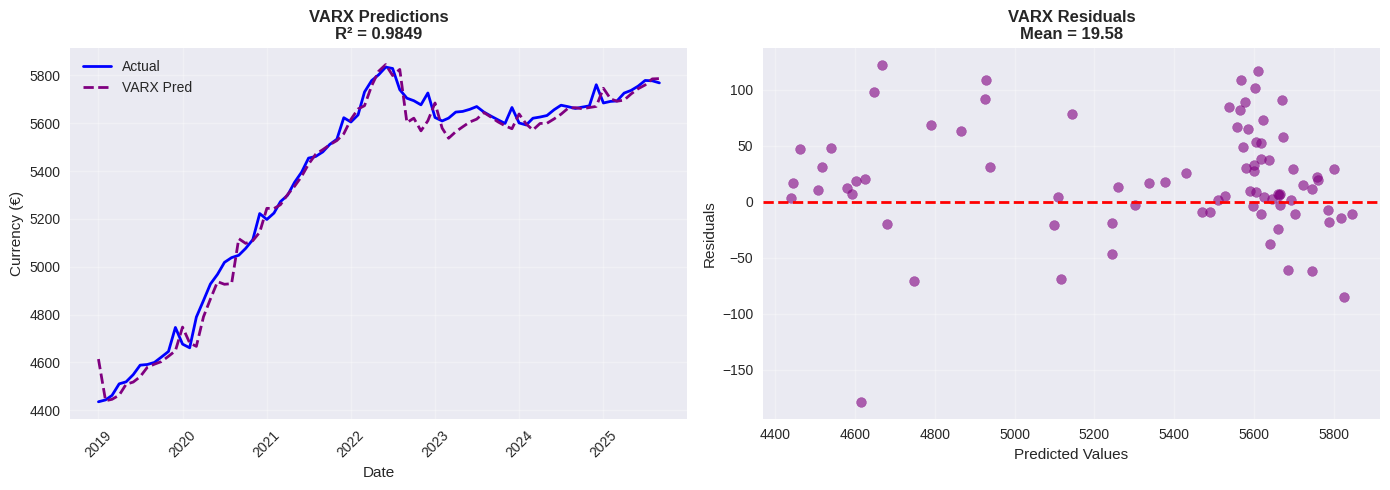

In [ ]:
# =============================================================================
# VARX MODEL (Vector Autoregression with Exogenous Variables)
# =============================================================================
from statsmodels.tsa.api import VAR

print("\n" + "="*80)
print("VARX MODEL (Vector Autoregression)")
print("="*80)

# Select variables for VARX - keep it small to avoid overfitting
var_endogs = ['Currency in circulation', 'Credit', 'To general government in the euro area']
exog_for_var = ['ECB_Deposit_Rate']

# Prepare data for VARX
df_var = df[var_endogs + exog_for_var].copy()
df_var = df_var.dropna()

print(f"VARX dataset shape: {df_var.shape}")
print(f"Endogenous variables: {var_endogs}")
print(f"Exogenous variables: {exog_for_var}")

# Function to fit VARX model
def fit_varx(train_df, maxlags=2):
    """Fit VARX model"""
    endog = train_df[var_endogs]
    exog = train_df[exog_for_var]

    model = VAR(endog, exog=exog)
    res = model.fit(maxlags=maxlags, ic='aic')
    return res

# Fit on full data to check model
print("\nFitting VARX model on full dataset...")
varx_model = fit_varx(df_var, maxlags=2)

if varx_model:
    print(f"\nVARX Model Summary:")
    print(f"Selected lag order: {varx_model.k_ar}")
    print(f"AIC: {varx_model.aic:.2f}")
    print(f"BIC: {varx_model.bic:.2f}")
    print(f"HQIC: {varx_model.hqic:.2f}")

# Rolling window evaluation for VARX
def rolling_varx_evaluate(data, initial_train=60):
    """Rolling window evaluation for VARX model"""
    preds = []
    actuals = []
    dates = []

    for i in range(initial_train, len(data)):
        # Training data
        train_data = data.iloc[:i]

        # Test point
        test_data = data.iloc[i:i+1]

        try:
            # Fit model on training data
            model = fit_varx(train_data, maxlags=2)

            # Make one-step ahead forecast
            # Get last observations for forecasting
            lag_order = model.k_ar

            # Prepare data for forecast
            forecast_input_endog = train_data[var_endogs].values[-lag_order:]
            forecast_input_exog = test_data[exog_for_var].values

            # Make forecast
            forecast = model.forecast(
                y=forecast_input_endog,
                steps=1,
                exog_future=forecast_input_exog
            )

            # Extract prediction for Currency in circulation (first variable)
            pred = forecast[0, 0]  # First row, first column
            actual = test_data[var_endogs[0]].iloc[0]

            preds.append(pred)
            actuals.append(actual)
            dates.append(test_data.index[0])

        except Exception as e:
            print(f"Error at step {i}: {e}")
            continue

    # Calculate metrics
    preds_array = np.array(preds)
    actuals_array = np.array(actuals)

    metrics = {
        'r2': r2_score(actuals_array, preds_array),
        'rmse': np.sqrt(mean_squared_error(actuals_array, preds_array)),
        'mae': mean_absolute_error(actuals_array, preds_array),
        'predictions': preds_array,
        'actuals': actuals_array,
        'dates': dates
    }

    return metrics

# Run rolling evaluation
print("\nRunning VARX rolling window evaluation...")
varx_metrics = rolling_varx_evaluate(df_var, initial_train=60)

print(f"\nVARX ROLLING WINDOW PERFORMANCE:")
print(f"{'Metric':<10} {'Value':<10}")
print("-" * 25)
print(f"{'R²':<10} {varx_metrics['r2']:<10.4f}")
print(f"{'RMSE':<10} {varx_metrics['rmse']:<10.2f}")
print(f"{'MAE':<10} {varx_metrics['mae']:<10.2f}")

# Plot VARX results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Predictions vs Actual
axes[0].plot(varx_metrics['dates'], varx_metrics['actuals'], 'b-', label='Actual', linewidth=2)
axes[0].plot(varx_metrics['dates'], varx_metrics['predictions'], 'purple', linestyle='--', label='VARX Pred', linewidth=2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Currency (€)')
axes[0].set_title(f'VARX Predictions\nR² = {varx_metrics["r2"]:.4f}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. Residuals
residuals_varx = varx_metrics['actuals'] - varx_metrics['predictions']
axes[1].scatter(varx_metrics['predictions'], residuals_varx, alpha=0.6, s=50, color='purple')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'VARX Residuals\nMean = {residuals_varx.mean():.2f}', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save VARX predictions
varx_predictions = {
    'test_pred': varx_metrics['predictions'],
    'test_actual': varx_metrics['actuals'],
    'test_r2': varx_metrics['r2'],
    'test_mae': varx_metrics['mae'],
    'test_rmse': varx_metrics['rmse'],
    'model': varx_model,
    'lag_order': varx_model.k_ar if varx_model else None
}

R2 is 0.98 very good fit,low error ,so good accuracy,MAE higher than SARIMAX and State space.Checking residuals,model is unbiased but has few large errors .

VARX captures interdependencies between multiple economic indicators.

It is useful when target is influenced by other endogenous series (like credit or government flows).

The rolling R² of 0.9849 puts it just behind State Space (0.9954) and SARIMAX (0.9762), and ahead of all ML models.

# Final comparison

In [123]:
# =============================================================================
# FINAL COMPARISON TABLE
# =============================================================================
import pandas as pd

comparison_df = pd.DataFrame([
    {
        'Model': 'Ridge Regression',
        'Train R²': 0.9937,
        'Test R²': 0.7579,
        'CV R²': -0.9275,
        'Test MAE': 60.30,
        'Test RMSE': 69.78,
        'Rolling R²': 0.8696
    },
    {
        'Model': 'XGBoost',
        'Train R²': 0.9993,
        'Test R²': -21.2242,
        'CV R²': -2.2399,
        'Test MAE': 641.3011,
        'Test RMSE': 668.5200,
        'Rolling R²': 0.5871
    },
    {
        'Model': 'Random Forest',
        'Train R²': 0.9984,
        'Test R²': -12.4072,
        'CV R²': -2.7415,
        'Test MAE': 498.4136,
        'Test RMSE': 519.2421,
        'Rolling R²': 0.8428
    },
    {
        'Model': 'Ensemble (Avg ML)',
        'Train R²': 0.9984,
        'Test R²': -6.5266,
        'CV R²': -1.9696,
        'Test MAE': 374.6876,
        'Test RMSE': 389.0456,
        'Rolling R²': 0.8720
    },
    {
        'Model': 'SARIMAX',
        'Train R²': None,
        'Test R²': 0.9762,
        'CV R²': None,
        'Test MAE': 26.40,
        'Test RMSE': 45.45,
        'Rolling R²': 0.9762
    },
    {
        'Model': 'State Space',
        'Train R²': None,
        'Test R²': 0.9954,
        'CV R²': None,
        'Test MAE': 19.3344,
        'Test RMSE': 29.5330,
        'Rolling R²': 0.9954
    },
    {
        'Model': 'VARX',
        'Train R²': None,
        'Test R²': 0.9849,
        'CV R²': None,
        'Test MAE': 39.2471,
        'Test RMSE': 53.4153,
        'Rolling R²': 0.9849
    }
]).round(4)

print("\nFINAL MODEL COMPARISON TABLE:")
print(comparison_df.to_string(index=False))



FINAL MODEL COMPARISON TABLE:
            Model  Train R²  Test R²   CV R²  Test MAE  Test RMSE  Rolling R²
 Ridge Regression    0.9937   0.7579 -0.9275   60.3000    69.7800      0.8696
          XGBoost    0.9993 -21.2242 -2.2399  641.3011   668.5200      0.5871
    Random Forest    0.9984 -12.4072 -2.7415  498.4136   519.2421      0.8428
Ensemble (Avg ML)    0.9984  -6.5266 -1.9696  374.6876   389.0456      0.8720
          SARIMAX       NaN   0.9762     NaN   26.4000    45.4500      0.9762
      State Space       NaN   0.9954     NaN   19.3344    29.5330      0.9954
             VARX       NaN   0.9849     NaN   39.2471    53.4153      0.9849


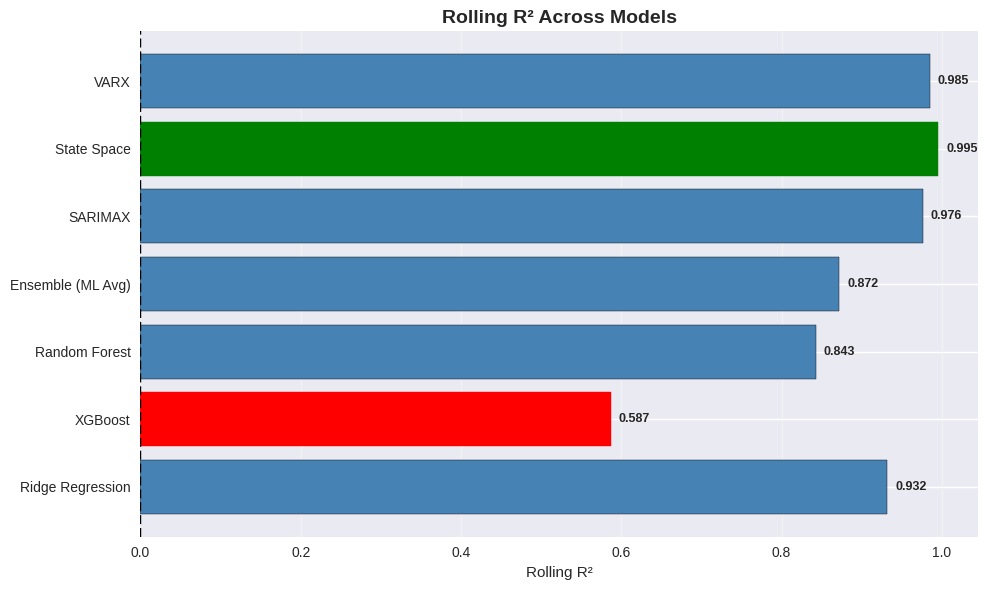

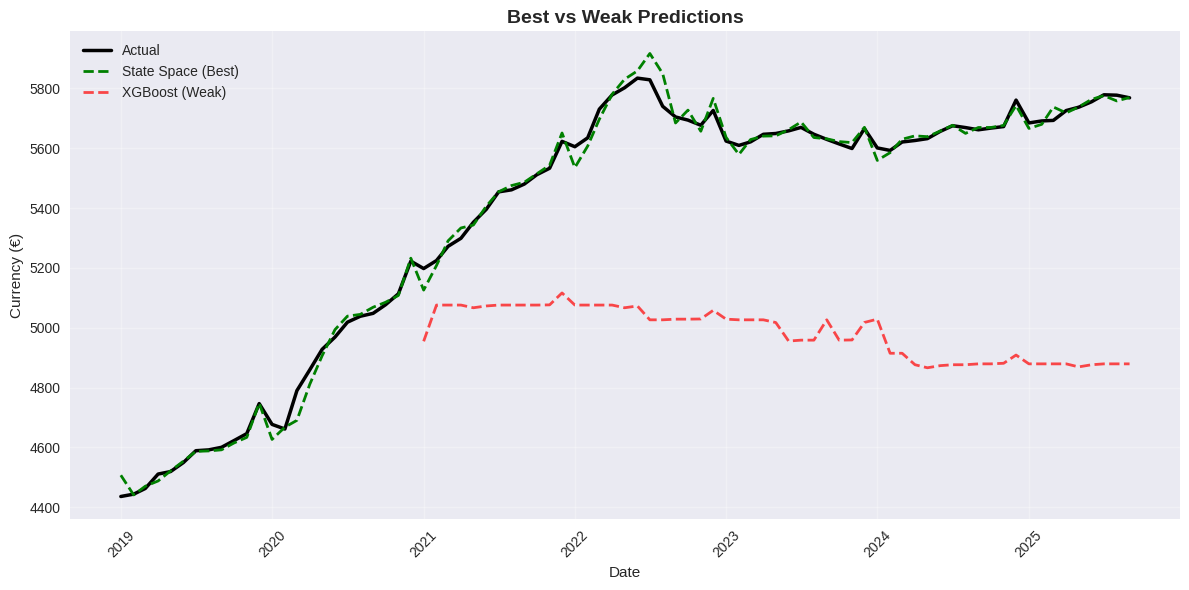

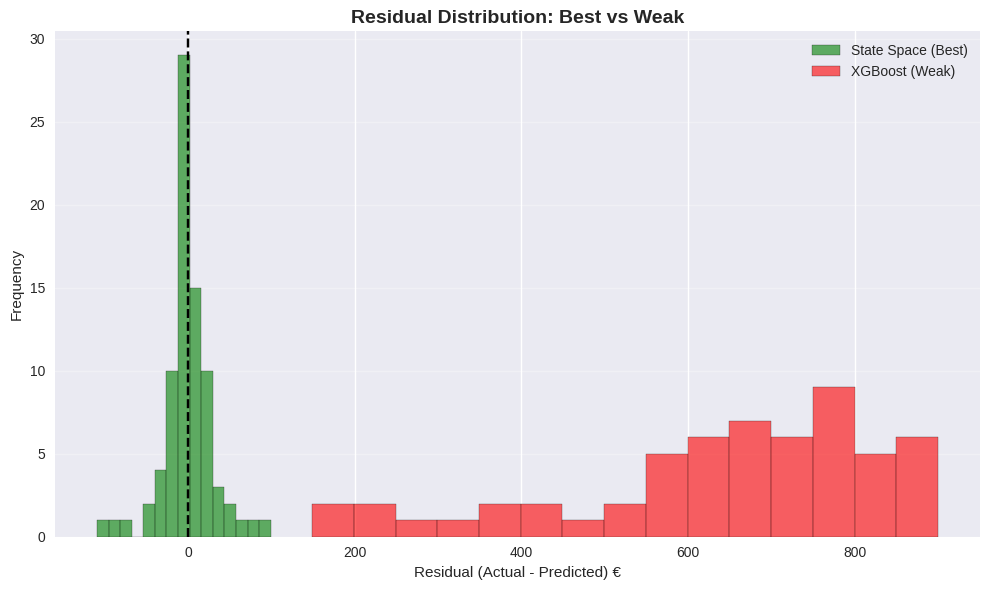

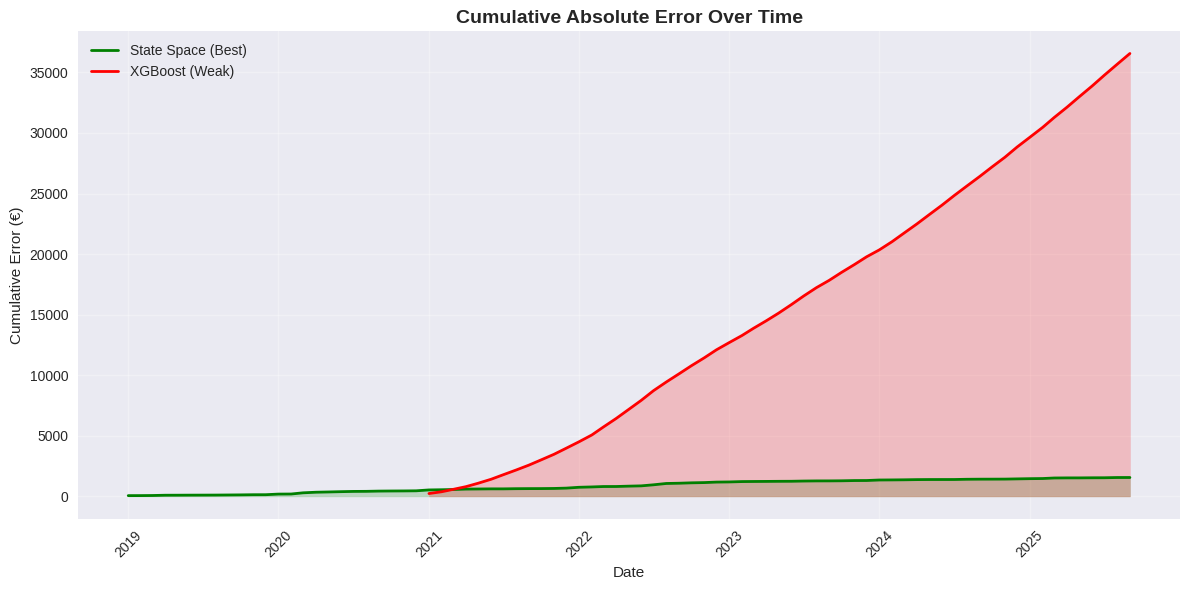

In [124]:
# =============================================================================
# BEST vs WEAK MODELS (with original data)
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8")

# Build DataFrame of R² values
models = ["Ridge Regression","XGBoost","Random Forest","Ensemble (ML Avg)","SARIMAX","State Space","VARX"]
test_r2 = [0.7579, -21.2242, -12.4072, -6.5266, 0.9762, 0.9954, 0.9849]
rolling_r2 = [0.9319, 0.5871, 0.8428, 0.8720, 0.9762, 0.9954, 0.9849]

df_r2 = pd.DataFrame({"Model": models,"Test R²": test_r2,"Rolling R²": rolling_r2})

# Identify best/weak
best_idx = df_r2["Rolling R²"].idxmax()
weak_idx = df_r2["Rolling R²"].idxmin()
best_model = df_r2.loc[best_idx,"Model"]
weak_model = df_r2.loc[weak_idx,"Model"]

# 1. Rolling R² Bar Chart
plt.figure(figsize=(10,6))
bars = plt.barh(df_r2["Model"], df_r2["Rolling R²"], color="steelblue", edgecolor="black")
bars[best_idx].set_color("green")
bars[weak_idx].set_color("red")
for bar, r2 in zip(bars, df_r2["Rolling R²"]):
    plt.text(r2+0.01, bar.get_y()+bar.get_height()/2, f"{r2:.3f}", va="center", fontsize=9, fontweight="bold")
plt.axvline(x=0, color="black", linestyle="--")
plt.title("Rolling R² Across Models", fontsize=14, fontweight="bold")
plt.xlabel("Rolling R²")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# BEST vs WEAK MODEL COMPARISON (State Space vs XGBoost)
# =============================================================================

# Best model: State Space
best_actual = state_space_predictions['test_actual']
best_pred = state_space_predictions['test_pred']
best_dates = state_metrics['dates']

# Weak model: XGBoost
weak_actual = y_test.values   # actuals from test set
weak_pred = xgb_predictions['test_pred']
weak_dates = test_dates

# Residuals
best_residuals = np.array(best_actual) - np.array(best_pred)
weak_residuals = np.array(weak_actual) - np.array(weak_pred)

# 1. Predictions vs Actual (Best vs Weak)
plt.figure(figsize=(12,6))
plt.plot(best_dates, best_actual, "k-", label="Actual", linewidth=2.5)
plt.plot(best_dates, best_pred, "g--", label="State Space (Best)", linewidth=2)
plt.plot(weak_dates, weak_pred, "r--", label="XGBoost (Weak)", linewidth=2, alpha=0.7)
plt.title("Best vs Weak Predictions", fontsize=14, fontweight="bold")
plt.xlabel("Date"); plt.ylabel("Currency (€)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Residual Distribution (Best vs Weak)
plt.figure(figsize=(10,6))
plt.hist(best_residuals, bins=15, color="green", alpha=0.6, edgecolor="black", label="State Space (Best)")
plt.hist(weak_residuals, bins=15, color="red", alpha=0.6, edgecolor="black", label="XGBoost (Weak)")
plt.axvline(x=0, color="black", linestyle="--")
plt.title("Residual Distribution: Best vs Weak", fontsize=14, fontweight="bold")
plt.xlabel("Residual (Actual - Predicted) €")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Cumulative Error Over Time
cumulative_best_error = np.cumsum(np.abs(best_residuals))
cumulative_weak_error = np.cumsum(np.abs(weak_residuals))

plt.figure(figsize=(12,6))
plt.plot(best_dates, cumulative_best_error, "g-", label="State Space (Best)", linewidth=2)
plt.plot(weak_dates, cumulative_weak_error, "r-", label="XGBoost (Weak)", linewidth=2)
plt.fill_between(best_dates, 0, cumulative_best_error, color="green", alpha=0.2)
plt.fill_between(weak_dates, 0, cumulative_weak_error, color="red", alpha=0.2)
plt.title("Cumulative Absolute Error Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Date"); plt.ylabel("Cumulative Error (€)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The State Space model shows tightly clustered residuals and low cumulative error, indicating stable, accurate forecasts. In contrast, XGBoost accumulates large errors over time, revealing poor generalization for this dataset.

**Why some models were not selected?**


---


1.ARIMA/SARIMA
 Not used because they only rely on the target’s own history, while SARIMAX was chosen instead as it incorporates seasonality and exogenous drivers like ECB Deposit Rate and Deposit Facility, making it more suitable for this dataset

2.AdaBoost, CatBoost, LightGBM

Adaboost not suited for sequential/temporal dependencies. It tends to struggle with autocorrelation in time series.Catboost and lightgbm-They require careful feature engineering.Risk of overfitting is high with small samples.

3.MLP, LSTM, GRU are popular for time series

They need large datasets to generalize well. With ~141 monthly points, deep nets are prone to overfitting.

Training is computationally heavier and less interpretable compared to econometric models.

4.Linear and Lasso regression

We already used Ridge Regression, which is essentially Linear Regression with L2 regularization.

Plain Linear Regression often struggles with multicollinearity (when predictors are correlated), which is common in macroeconomic datasets.

Ridge stabilizes coefficients and prevents them from blowing up, making it more robust for small sample size.Ridge balances bias-variance tradeoff better for small, correlated datasets.

Lasso uses L1 regularization, which can shrink some coefficients to zero (feature selection).

With only a handful of exogenous variables (ECB rates, credit, etc.), feature selection is not as critical ,there are no hundreds of predictors.

Lasso tends to be unstable in small samples because it can drop important variables entirely.

5.Prophet

 Not used because: small dataset, less interpretability, and econometric models were better suited

6.ETS (Error–Trend–Seasonal models)

ETS models (including Holt–Winters exponential smoothing) decompose a series into error, trend, and seasonal components. While they are effective for short‑term forecasts with strong seasonality, they do not incorporate exogenous drivers such as ECB rates or credit. Since our dataset depends heavily on external policy variables, ETS was not used. Instead, SARIMAX, State Space, and VARX provided more flexible and interpretable frameworks.

**Why our models used in experiment were selected?**


---


Econometric models (SARIMAX, State Space, VARX): Handle small samples, seasonality, exogenous drivers, and are interpretable.

ML models (Ridge, RF, XGBoost): Provide benchmarks for nonlinear relationships and ensemble comparisons.

Together, they give a balanced view: interpretable econometrics + flexible ML

**References**

---


1. https://statdb.bank.lv/lb/Data/208 (dataset)

2. https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html(ECB rates)

3. https://www.semanticscholar.org/paper/Evaluating-the-Performance-of-Machine-Learning-in-A-Ryll-Seidens/74f74773d6147ec759a4eba3200d3ae6c5f01e22

4. https://link-springer-com.uwe.idm.oclc.org/article/10.1186/s40537-022-00676-2

5. https://ajpojournals.org/journals/EJT/article/view/2005/2428 robustness and interpretability..

6. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3031796 machine learning at central banks

7. https://readmedium.com/arima-vs-sarima-vs-sarimax-vs-prophet-for-time-series-forecasting-a59d3cc932a3

8. https://www.elibrary.imf.org/view/journals/002/2022/101/002.2022.issue-101-en.xml

9. https://dc.cbn.gov.ng/cgi/viewcontent.cgi?article=1126&context=jas money circulation in nigeria

10. https://pre.econ.upd.edu.ph/index.php/pre/article/view/1068/1010 Philippine

11. https://datnes.latvijasbanka.lv/papers/WP_1_2025.pdf

12.  https://www.ecb.europa.eu/press/economic-bulletin/articles/2021/html/ecb.ebart202105_02~c429c01d24.en.html

13. https://www.lituanistika.lt/content/75639